In [1]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:\Work_with_MM")

# Verify the change
print(os.getcwd())

H:\Work_with_MM


Processed 00_001: KGE = 0.2078
Processed 00_002: KGE = -0.7519
Processed 00_003: KGE = -0.1575
Processed 00_004: KGE = -0.0338
Processed 00_005: KGE = 0.0385
Processed 00_006: KGE = 0.3938
Processed 00_007: KGE = -1.6601
Processed 00_008: KGE = 0.0696
Processed 00_009: KGE = 0.0256
Processed 00_010: KGE = -2.3339
Processed 00_011: KGE = -0.8477
Processed 00_012: KGE = -0.9199
Processed 00_013: KGE = -0.8176
Processed 00_014: KGE = -1.7678
Processed 00_015: KGE = -0.5559
Processed 00_016: KGE = 0.0955
Processed 00_017: KGE = 0.2327
Processed 00_018: KGE = -1.3162
Processed 00_019: KGE = -1.1263
Processed 00_020: KGE = -1.2527
Processed 00_021: KGE = -0.8853
Processed 00_022: KGE = -2.2899
Processed 00_023: KGE = -0.3123
Processed 00_024: KGE = -0.1386
Processed 00_025: KGE = -0.0452
Processed 00_026: KGE = -1.2691
Processed 00_027: KGE = 0.3493
Processed 00_028: KGE = 0.0374
Processed 00_029: KGE = 0.0042
Processed 00_030: KGE = -0.5605
Processed 00_031: KGE = 0.2863
Processed 00_032: K

[19:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 5375/5377 [00:37<00:00]        

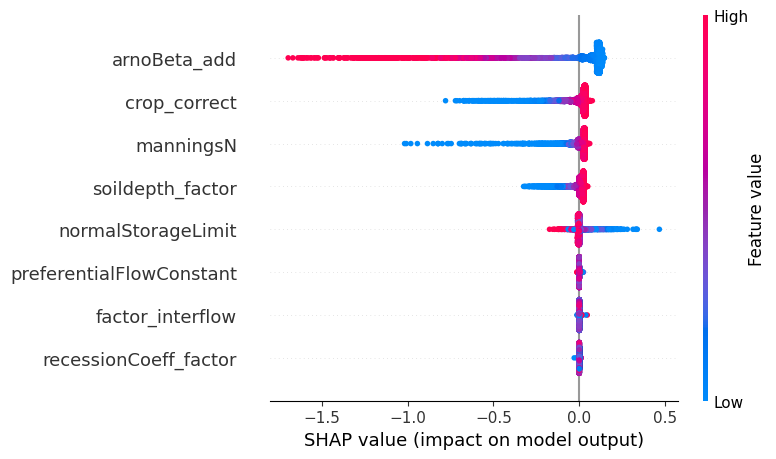

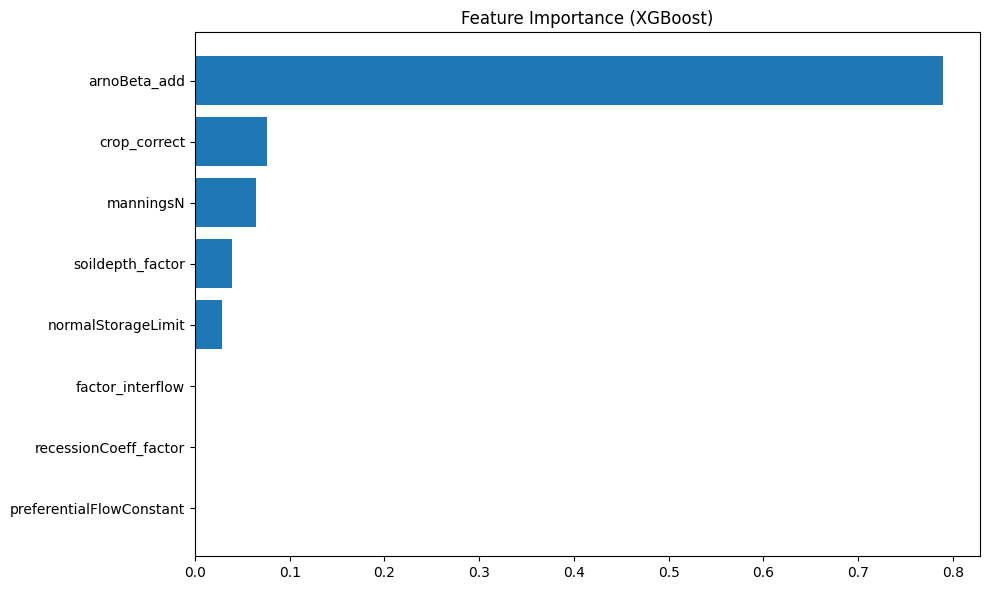


KGE Statistics:
Min: -3.3009
Max: 0.5949
Mean: 0.3375
Std: 0.4627


In [19]:
import os
import configparser
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# ---------- 1. ÿ™ÿßÿ®ÿπ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá KGE ----------
def calc_kge(sim, obs):
    sim, obs = np.array(sim), np.array(obs)
    cc = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# ---------- 2. ÿ¢ÿØÿ±ÿ≥‚ÄåŸáÿß ----------
base_dir = r"H:\Work_with_MM\CWatM_modified\Toolkit\Calibration\runs_calibration3"
obs_file = r"H:\Work_with_MM\Data_GCM\Daily_Dis_Observation.csv"

# ---------- 3. ÿØÿßÿØŸá‚ÄåŸáÿß€å ŸÖÿ¥ÿßŸáÿØÿßÿ™€å ----------
obs = pd.read_csv(obs_file, parse_dates=True, index_col=0)
obs = obs["discharge"].values  # ŸÅÿ±ÿ∂: ÿ≥ÿ™ŸàŸÜ discharge

# ---------- 4. ÿÆŸàÿßŸÜÿØŸÜ ŸÜÿ™ÿß€åÿ¨ Ÿáÿ± ÿ±ÿßŸÜ ----------
params_list = []
kge_list = []

for run_dir in os.listdir(base_dir):
    run_path = os.path.join(base_dir, run_dir)
    if not os.path.isdir(run_path):
        continue

    # ŸÅÿß€åŸÑ ini - ÿ®ÿß ⁄Ü⁄© ⁄©ÿ±ÿØŸÜ Ÿàÿ¨ŸàÿØ ŸÅÿß€åŸÑ
    ini_file_candidate1 = os.path.join(run_path, f"settings_CWatM_template-Run{run_dir}.ini")
    ini_file_candidate2 = os.path.join(run_path, "calibration.ini")
    
    ini_file = None
    if os.path.exists(ini_file_candidate1):
        ini_file = ini_file_candidate1
    elif os.path.exists(ini_file_candidate2):
        ini_file = ini_file_candidate2
    else:
        print(f"INI file not found in {run_dir}")
        continue

    config = configparser.ConfigParser()
    config.read(ini_file)

    # Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß
    try:
        params = {
            "crop_correct": float(config.get("CALIBRATION", "crop_correct")),
            "soildepth_factor": float(config.get("CALIBRATION", "soildepth_factor")),
            "preferentialFlowConstant": float(config.get("CALIBRATION", "preferentialFlowConstant")),
            "arnoBeta_add": float(config.get("CALIBRATION", "arnoBeta_add")),
            "factor_interflow": float(config.get("CALIBRATION", "factor_interflow")),
            "recessionCoeff_factor": float(config.get("CALIBRATION", "recessionCoeff_factor")),
            "manningsN": float(config.get("CALIBRATION", "manningsN")),
            "normalStorageLimit": float(config.get("CALIBRATION", "normalStorageLimit")),
        }
    except (configparser.NoSectionError, configparser.NoOptionError) as e:
        print(f"Error reading parameters from {ini_file}: {e}")
        continue

    # ÿÆÿ±Ÿàÿ¨€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å (tss)
    tss_file = os.path.join(run_path, "discharge_daily.tss")
    if not os.path.exists(tss_file):
        print(f"TSS file not found: {tss_file}")
        continue

    try:
        # ÿÆŸàÿßŸÜÿØŸÜ ŸÅÿß€åŸÑ TSS - ÿ±Ÿàÿ¥ ÿ≥ÿßÿØŸá‚Äåÿ™ÿ± Ÿà ŸÖÿ∑ŸÖÿ¶ŸÜ‚Äåÿ™ÿ±
        # ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ÿÆÿ∑ 5 ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ (ŸáŸÖÿßŸÜÿ∑Ÿàÿ± ⁄©Ÿá ÿßÿ≤ ÿÆÿ±Ÿàÿ¨€å ÿØ€åÿ®ÿß⁄Ø ŸÖÿ¥ÿÆÿµ ÿßÿ≥ÿ™)
        sim = pd.read_csv(tss_file, sep=r'\s+', skiprows=4, header=None, engine='python')
        
        # ÿ≥ÿ™ŸàŸÜ ÿØŸàŸÖ ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿØÿ®€å ÿßÿ≥ÿ™
        if sim.shape[1] >= 2:
            sim = sim[1].values
        else:
            print(f"Not enough columns in {tss_file}")
            continue

        # ÿ≠ÿ∞ŸÅ ŸÖŸÇÿßÿØ€åÿ± NaN €åÿß inf
        sim = sim[np.isfinite(sim)]
        
        if len(sim) == 0:
            print(f"No valid data in {tss_file}")
            continue

        # ÿ∑ŸàŸÑ ÿØÿßÿØŸá‚ÄåŸáÿß ÿ±ÿß ŸáŸÖÿßŸáŸÜ⁄Ø ⁄©ŸÜ
        n = min(len(sim), len(obs))
        if n == 0:
            print(f"No overlapping data in {tss_file}")
            continue
            
        kge = calc_kge(sim[:n], obs[:n])

        params_list.append(params)
        kge_list.append(kge)
        print(f"Processed {run_dir}: KGE = {kge:.4f}")
        
    except Exception as e:
        print(f"Error processing {run_dir}: {e}")
        continue

# ---------- 5. ÿ≥ÿßÿÆÿ™ ÿØ€åÿ™ÿßŸÅÿ±€åŸÖ ----------
if len(params_list) == 0:
    print("No valid data found! Check your file paths and structure.")
    exit()

X = pd.DataFrame(params_list)
y = np.array(kge_list)

print("X shape:", X.shape)
print("y shape:", y.shape)
print(f"Number of successful runs: {len(params_list)}")

if len(params_list) < 2:
    print("Need at least 2 successful runs for modeling")
    exit()

# ---------- 6. ŸÖÿØŸÑ ML ----------
model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X, y)

# ---------- 7. SHAP ----------
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# ŸÜŸÖŸàÿØÿßÿ± ⁄©ŸÑ€å
shap.summary_plot(shap_values, X)

# ŸÜŸÖÿß€åÿ¥ ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# ŸÜŸÖÿß€åÿ¥ ÿ®ÿ±ÿÆ€å ÿ¢ŸÖÿßÿ±
print(f"\nKGE Statistics:")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")

Processed 00_001: KGE = 0.2078
Processed 00_002: KGE = -0.7519
Processed 00_003: KGE = -0.1575
Processed 00_004: KGE = -0.0338
Processed 00_005: KGE = 0.0385
Processed 00_006: KGE = 0.3938
Processed 00_007: KGE = -1.6601
Processed 00_008: KGE = 0.0696
Processed 00_009: KGE = 0.0256
Processed 00_010: KGE = -2.3339
Processed 00_011: KGE = -0.8477
Processed 00_012: KGE = -0.9199
Processed 00_013: KGE = -0.8176
Processed 00_014: KGE = -1.7678
Processed 00_015: KGE = -0.5559
Processed 00_016: KGE = 0.0955
Processed 00_017: KGE = 0.2327
Processed 00_018: KGE = -1.3162
Processed 00_019: KGE = -1.1263
Processed 00_020: KGE = -1.2527
Processed 00_021: KGE = -0.8853
Processed 00_022: KGE = -2.2899
Processed 00_023: KGE = -0.3123
Processed 00_024: KGE = -0.1386
Processed 00_025: KGE = -0.0452
Processed 00_026: KGE = -1.2691
Processed 00_027: KGE = 0.3493
Processed 00_028: KGE = 0.0374
Processed 00_029: KGE = 0.0042
Processed 00_030: KGE = -0.5605
Processed 00_031: KGE = 0.2863
Processed 00_032: K

[19:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 5367/5377 [00:45<00:00]        

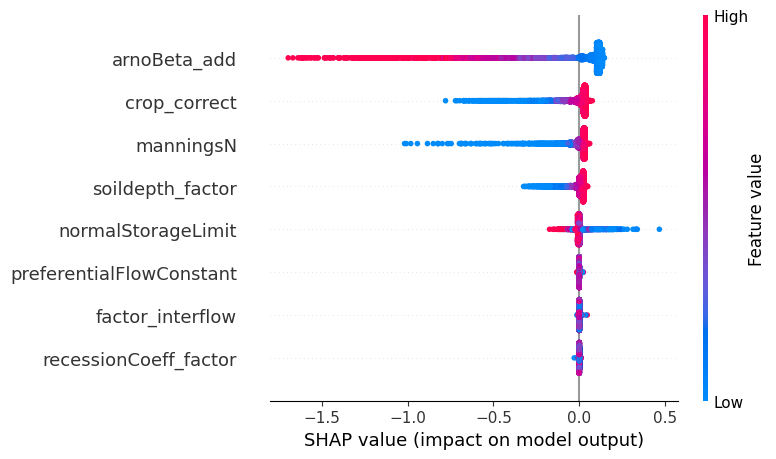

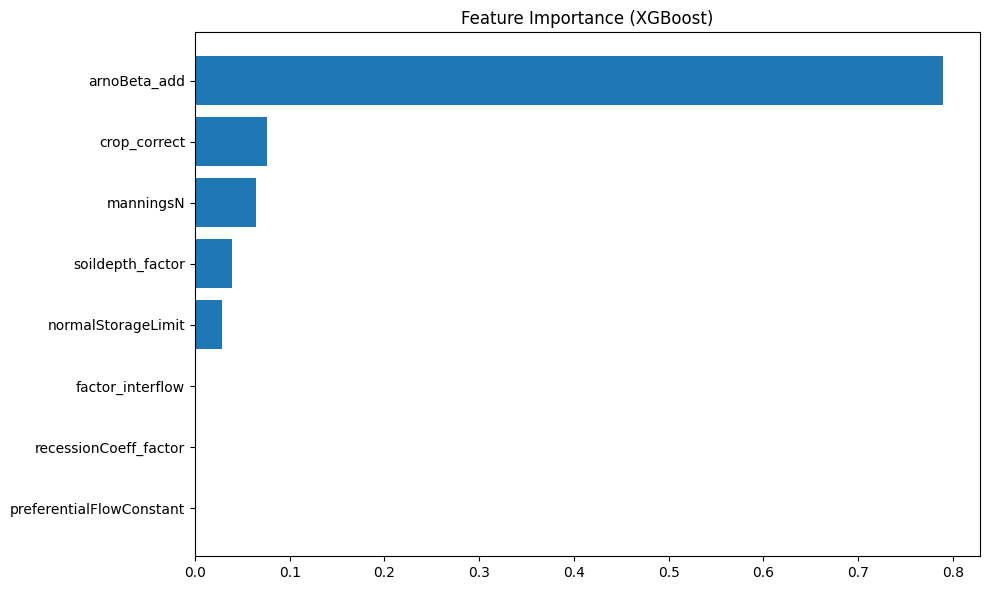


KGE Statistics:
Min: -3.3009
Max: 0.5949
Mean: 0.3375
Std: 0.4627
Could not add feature importance to Excel: [Errno 13] Permission denied: 'H:\\Work_with_MM\\KGE_7Prameters.xlsx'


In [20]:
import os
import configparser
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# ---------- 1. ÿ™ÿßÿ®ÿπ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá KGE ----------
def calc_kge(sim, obs):
    sim, obs = np.array(sim), np.array(obs)
    cc = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# ---------- 2. ÿ¢ÿØÿ±ÿ≥‚ÄåŸáÿß ----------
base_dir = r"H:\Work_with_MM\CWatM_modified\Toolkit\Calibration\runs_calibration3"
obs_file = r"H:\Work_with_MM\Data_GCM\Daily_Dis_Observation.csv"
output_excel = r"H:\Work_with_MM\KGE_7Prameters.xlsx"  # ŸÅÿß€åŸÑ ÿÆÿ±Ÿàÿ¨€å ÿß⁄©ÿ≥ŸÑ

# ---------- 3. ÿØÿßÿØŸá‚ÄåŸáÿß€å ŸÖÿ¥ÿßŸáÿØÿßÿ™€å ----------
obs = pd.read_csv(obs_file, parse_dates=True, index_col=0)
obs = obs["discharge"].values  # ŸÅÿ±ÿ∂: ÿ≥ÿ™ŸàŸÜ discharge

# ---------- 4. ÿÆŸàÿßŸÜÿØŸÜ ŸÜÿ™ÿß€åÿ¨ Ÿáÿ± ÿ±ÿßŸÜ ----------
params_list = []
kge_list = []
run_names = []  # ÿ®ÿ±ÿß€å ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿßŸÖ ÿ±ÿßŸÜ‚ÄåŸáÿß

for run_dir in os.listdir(base_dir):
    run_path = os.path.join(base_dir, run_dir)
    if not os.path.isdir(run_path):
        continue

    # ŸÅÿß€åŸÑ ini - ÿ®ÿß ⁄Ü⁄© ⁄©ÿ±ÿØŸÜ Ÿàÿ¨ŸàÿØ ŸÅÿß€åŸÑ
    ini_file_candidate1 = os.path.join(run_path, f"settings_CWatM_template-Run{run_dir}.ini")
    ini_file_candidate2 = os.path.join(run_path, "calibration.ini")
    
    ini_file = None
    if os.path.exists(ini_file_candidate1):
        ini_file = ini_file_candidate1
    elif os.path.exists(ini_file_candidate2):
        ini_file = ini_file_candidate2
    else:
        print(f"INI file not found in {run_dir}")
        continue

    config = configparser.ConfigParser()
    config.read(ini_file)

    # Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß
    try:
        params = {
            "crop_correct": float(config.get("CALIBRATION", "crop_correct")),
            "soildepth_factor": float(config.get("CALIBRATION", "soildepth_factor")),
            "preferentialFlowConstant": float(config.get("CALIBRATION", "preferentialFlowConstant")),
            "arnoBeta_add": float(config.get("CALIBRATION", "arnoBeta_add")),
            "factor_interflow": float(config.get("CALIBRATION", "factor_interflow")),
            "recessionCoeff_factor": float(config.get("CALIBRATION", "recessionCoeff_factor")),
            "manningsN": float(config.get("CALIBRATION", "manningsN")),
            "normalStorageLimit": float(config.get("CALIBRATION", "normalStorageLimit")),
        }
    except (configparser.NoSectionError, configparser.NoOptionError) as e:
        print(f"Error reading parameters from {ini_file}: {e}")
        continue

    # ÿÆÿ±Ÿàÿ¨€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å (tss)
    tss_file = os.path.join(run_path, "discharge_daily.tss")
    if not os.path.exists(tss_file):
        print(f"TSS file not found: {tss_file}")
        continue

    try:
        # ÿÆŸàÿßŸÜÿØŸÜ ŸÅÿß€åŸÑ TSS - ÿ±Ÿàÿ¥ ÿ≥ÿßÿØŸá‚Äåÿ™ÿ± Ÿà ŸÖÿ∑ŸÖÿ¶ŸÜ‚Äåÿ™ÿ±
        # ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ÿÆÿ∑ 5 ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ (ŸáŸÖÿßŸÜÿ∑Ÿàÿ± ⁄©Ÿá ÿßÿ≤ ÿÆÿ±Ÿàÿ¨€å ÿØ€åÿ®ÿß⁄Ø ŸÖÿ¥ÿÆÿµ ÿßÿ≥ÿ™)
        sim = pd.read_csv(tss_file, sep=r'\s+', skiprows=4, header=None, engine='python')
        
        # ÿ≥ÿ™ŸàŸÜ ÿØŸàŸÖ ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿØÿ®€å ÿßÿ≥ÿ™
        if sim.shape[1] >= 2:
            sim = sim[1].values
        else:
            print(f"Not enough columns in {tss_file}")
            continue

        # ÿ≠ÿ∞ŸÅ ŸÖŸÇÿßÿØ€åÿ± NaN €åÿß inf
        sim = sim[np.isfinite(sim)]
        
        if len(sim) == 0:
            print(f"No valid data in {tss_file}")
            continue

        # ÿ∑ŸàŸÑ ÿØÿßÿØŸá‚ÄåŸáÿß ÿ±ÿß ŸáŸÖÿßŸáŸÜ⁄Ø ⁄©ŸÜ
        n = min(len(sim), len(obs))
        if n == 0:
            print(f"No overlapping data in {tss_file}")
            continue
            
        kge = calc_kge(sim[:n], obs[:n])

        params_list.append(params)
        kge_list.append(kge)
        run_names.append(run_dir)  # ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿßŸÖ ÿ±ÿßŸÜ
        print(f"Processed {run_dir}: KGE = {kge:.4f}")
        
    except Exception as e:
        print(f"Error processing {run_dir}: {e}")
        continue

# ---------- 5. ÿ≥ÿßÿÆÿ™ ÿØ€åÿ™ÿßŸÅÿ±€åŸÖ ----------
if len(params_list) == 0:
    print("No valid data found! Check your file paths and structure.")
    exit()

X = pd.DataFrame(params_list)
y = np.array(kge_list)

# ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÜÿßŸÖ ÿ±ÿßŸÜ Ÿà KGE ÿ®Ÿá ÿØ€åÿ™ÿßŸÅÿ±€åŸÖ X
X['run_name'] = run_names
X['KGE'] = y

print("X shape:", X.shape)
print("y shape:", y.shape)
print(f"Number of successful runs: {len(params_list)}")

# ---------- 6. ÿ∞ÿÆ€åÿ±Ÿá ÿØÿ± ŸÅÿß€åŸÑ ÿß⁄©ÿ≥ŸÑ ----------
try:
    # ÿß€åÿ¨ÿßÿØ €å⁄© ExcelWriter ÿ®ÿ±ÿß€å ÿ∞ÿÆ€åÿ±Ÿá ⁄ÜŸÜÿØ€åŸÜ sheet
    with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
        # ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ⁄©ÿßŸÖŸÑ (X + y)
        X.to_excel(writer, sheet_name='All_Data', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸÅŸÇÿ∑ Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß (X)
        X_params = X.drop(['run_name', 'KGE'], axis=1)
        X_params.to_excel(writer, sheet_name='Parameters', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá KGE Ÿáÿß (y)
        kge_df = pd.DataFrame({
            'run_name': run_names,
            'KGE': y
        })
        kge_df.to_excel(writer, sheet_name='KGE_Values', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿ¢ŸÖÿßÿ± ÿ™Ÿàÿµ€åŸÅ€å
        stats_df = pd.DataFrame({
            'Statistic': ['Count', 'Mean', 'Std', 'Min', 'Max', '25%', '50%', '75%'],
            'KGE': [
                len(y),
                np.mean(y),
                np.std(y),
                np.min(y),
                np.max(y),
                np.percentile(y, 25),
                np.percentile(y, 50),
                np.percentile(y, 75)
            ]
        })
        stats_df.to_excel(writer, sheet_name='Statistics', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ÿ®€åŸÜ Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß Ÿà KGE
        correlation_data = []
        for param in X_params.columns:
            corr = np.corrcoef(X_params[param], y)[0, 1]
            correlation_data.append({'Parameter': param, 'Correlation_with_KGE': corr})
        
        corr_df = pd.DataFrame(correlation_data)
        corr_df.to_excel(writer, sheet_name='Correlations', index=False)
    
    print(f"\nData successfully saved to: {output_excel}")
    print("Sheets created:")
    print("  - All_Data: Complete dataset with parameters and KGE values")
    print("  - Parameters: Only the calibration parameters")
    print("  - KGE_Values: Run names and their KGE values")
    print("  - Statistics: Descriptive statistics of KGE values")
    print("  - Correlations: Correlation between parameters and KGE")
    
except Exception as e:
    print(f"Error saving to Excel file: {e}")
    # ÿ∞ÿÆ€åÿ±Ÿá ÿ≥ÿßÿØŸá‚Äåÿ™ÿ± ÿØÿ± ÿµŸàÿ±ÿ™ ÿÆÿ∑ÿß
    try:
        simple_output = output_excel.replace('.xlsx', '_simple.xlsx')
        X.to_excel(simple_output, index=False)
        print(f"Simple data saved to: {simple_output}")
    except Exception as e2:
        print(f"Could not save any Excel file: {e2}")

# ---------- 7. ŸÖÿØŸÑ ML (ÿß⁄Øÿ± ÿØÿßÿØŸá ⁄©ÿßŸÅ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ) ----------
if len(params_list) < 2:
    print("Need at least 2 successful runs for modeling")
    exit()

model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_params, y)

# ---------- 8. SHAP ----------
explainer = shap.Explainer(model, X_params)
shap_values = explainer(X_params)

# ŸÜŸÖŸàÿØÿßÿ± ⁄©ŸÑ€å
shap.summary_plot(shap_values, X_params)

# ŸÜŸÖÿß€åÿ¥ ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X_params.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# ŸÜŸÖÿß€åÿ¥ ÿ®ÿ±ÿÆ€å ÿ¢ŸÖÿßÿ±
print(f"\nKGE Statistics:")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")

# ÿ∞ÿÆ€åÿ±Ÿá ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿØÿ± ÿß⁄©ÿ≥ŸÑ
try:
    # ÿ®ÿßÿ≤ ⁄©ÿ±ÿØŸÜ ŸÅÿß€åŸÑ ŸÖŸàÿ¨ŸàÿØ Ÿà ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ sheet ÿ¨ÿØ€åÿØ
    with pd.ExcelWriter(output_excel, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        feature_importance.to_excel(writer, sheet_name='Feature_Importance', index=False)
    print("Feature importance saved to Excel file")
except Exception as e:
    print(f"Could not add feature importance to Excel: {e}")

Data loaded successfully from Excel file
Data shape: (5377, 10)
Columns: ['crop_correct', 'soildepth_factor', 'preferentialFlowConstant', 'arnoBeta_add', 'factor_interflow', 'recessionCoeff_factor', 'manningsN', 'normalStorageLimit', 'run_name', 'KGE']

First 5 rows of data:
   crop_correct  soildepth_factor  preferentialFlowConstant  arnoBeta_add  \
0      1.235751          1.281048                  6.859113      0.108474   
1      1.576541          0.875025                  4.500981      0.891433   
2      1.486260          1.291231                  5.768497      0.401101   
3      0.916324          1.317238                  7.205576      0.016206   
4      1.510463          1.222929                  2.038560      0.246717   

   factor_interflow  recessionCoeff_factor  manningsN  normalStorageLimit  \
0          1.086829               5.598648   7.436221            0.295064   
1          2.189699               9.337311   9.928568            0.385947   
2          1.730831           

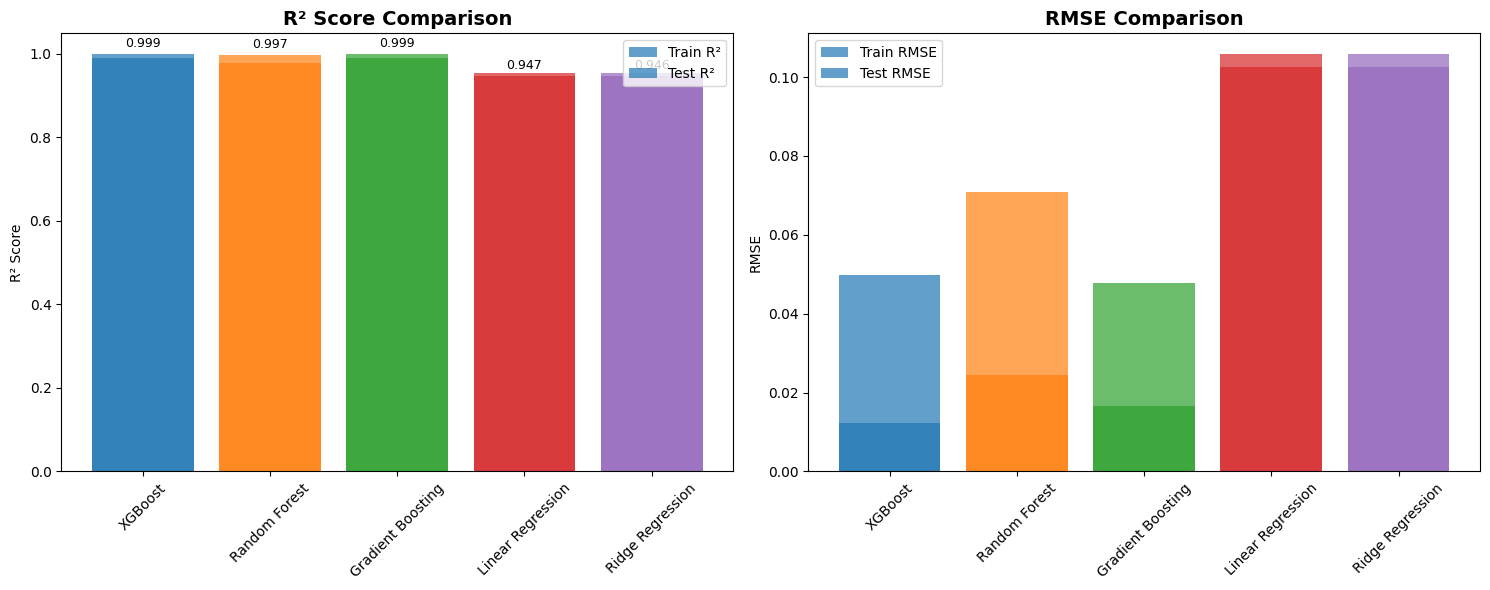

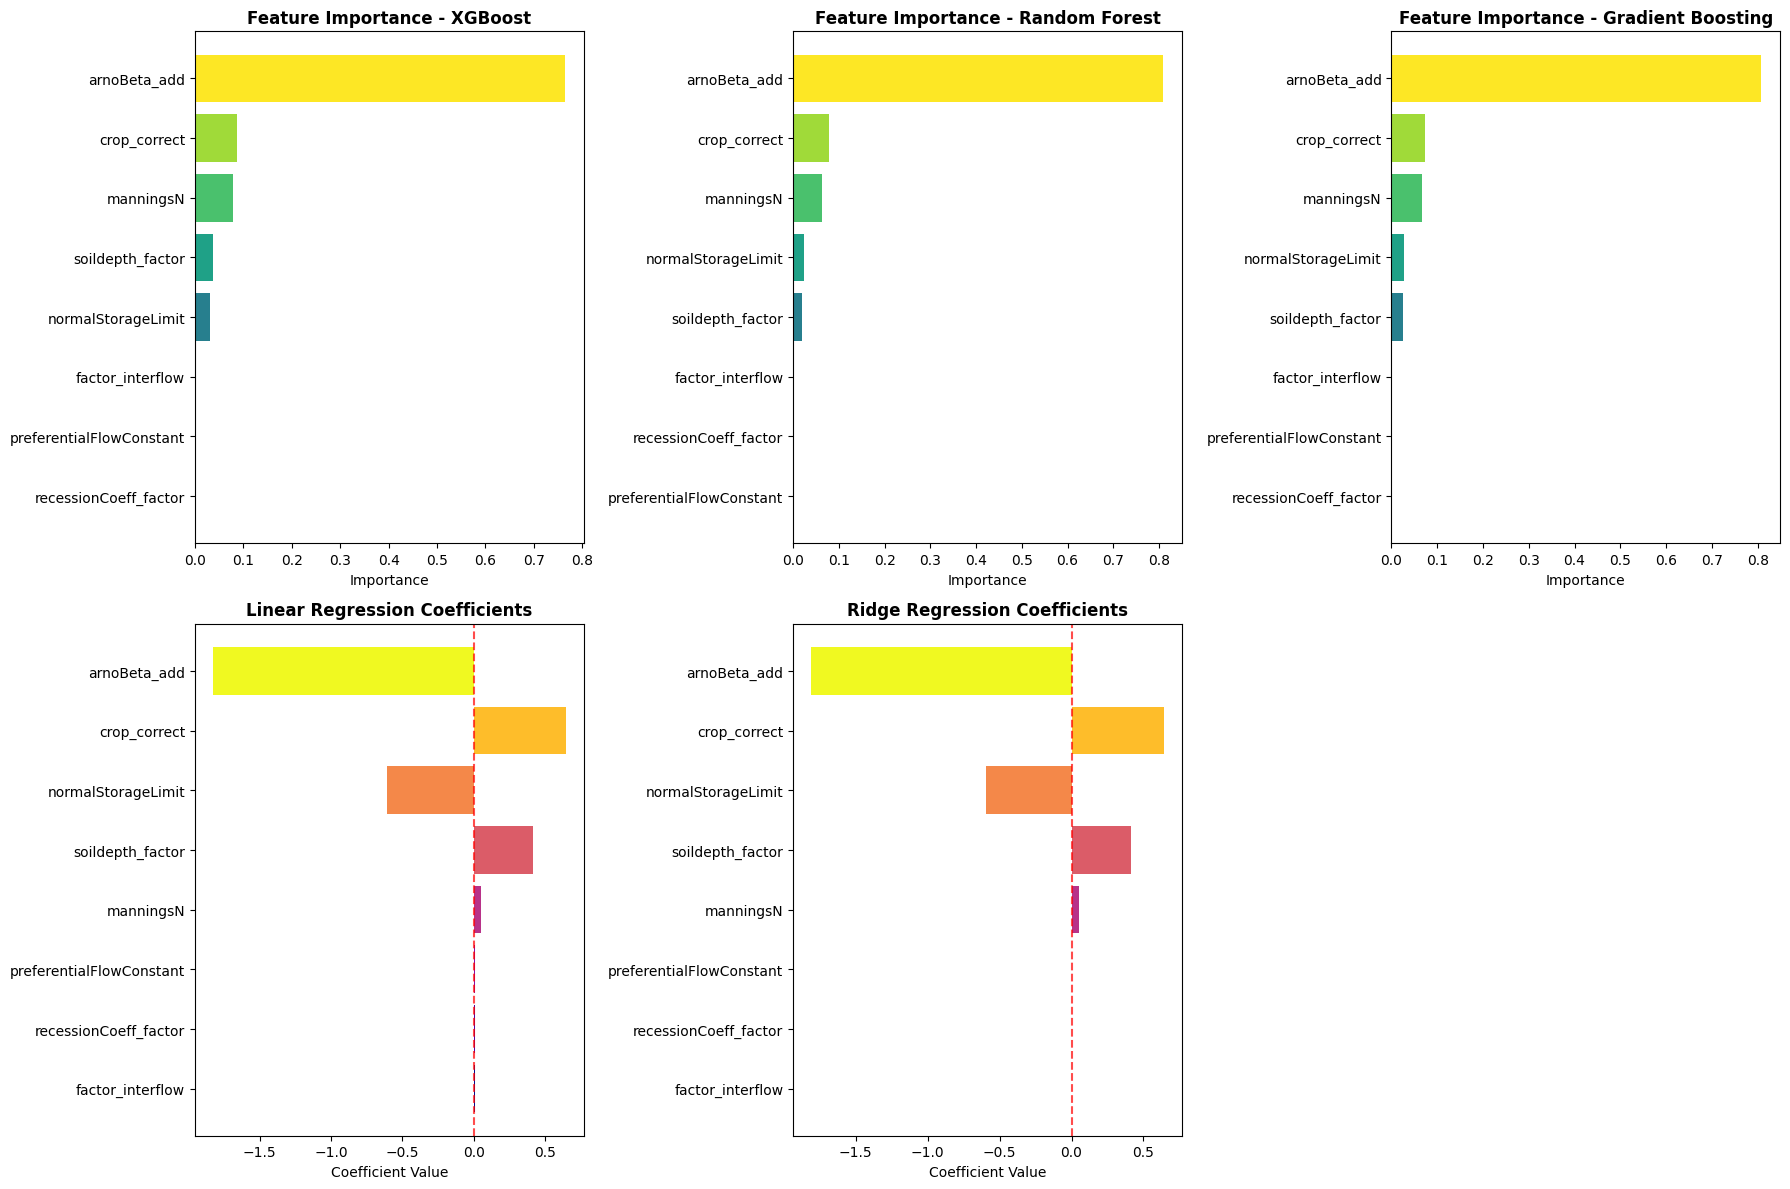


SHAP ANALYSIS

Generating SHAP analysis for XGBoost...


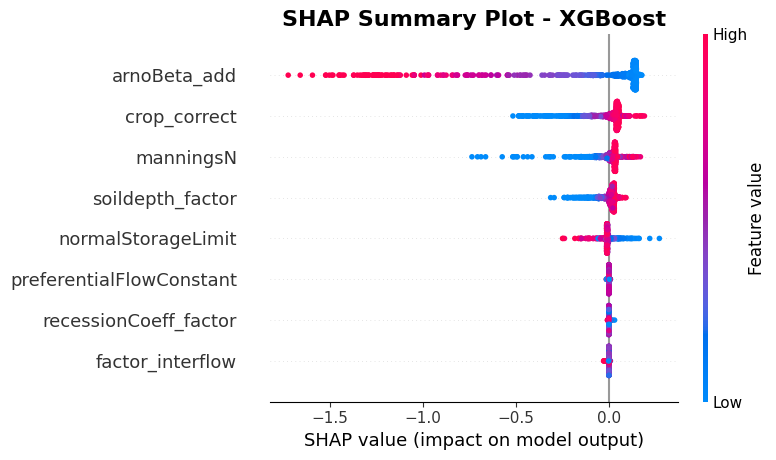

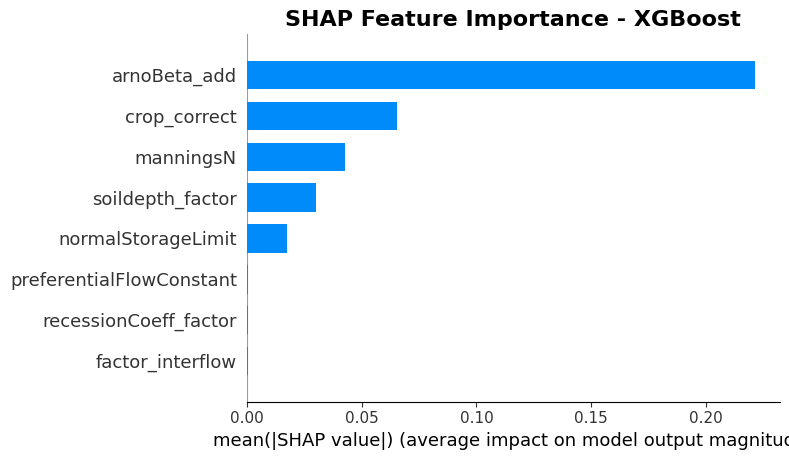

SHAP Feature Importance for XGBoost:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2211
0              crop_correct       0.0656
6                 manningsN       0.0426
1          soildepth_factor       0.0303
7        normalStorageLimit       0.0176
2  preferentialFlowConstant       0.0007
5     recessionCoeff_factor       0.0007
4          factor_interflow       0.0005
‚úÖ SHAP analysis completed for XGBoost

Generating SHAP analysis for Random Forest...


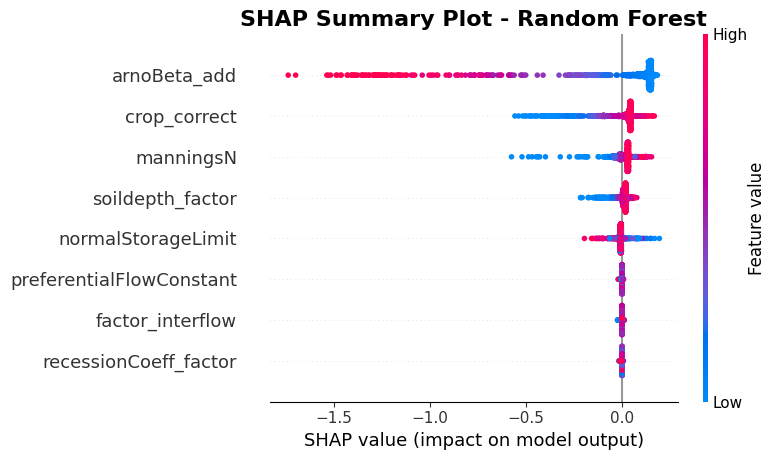

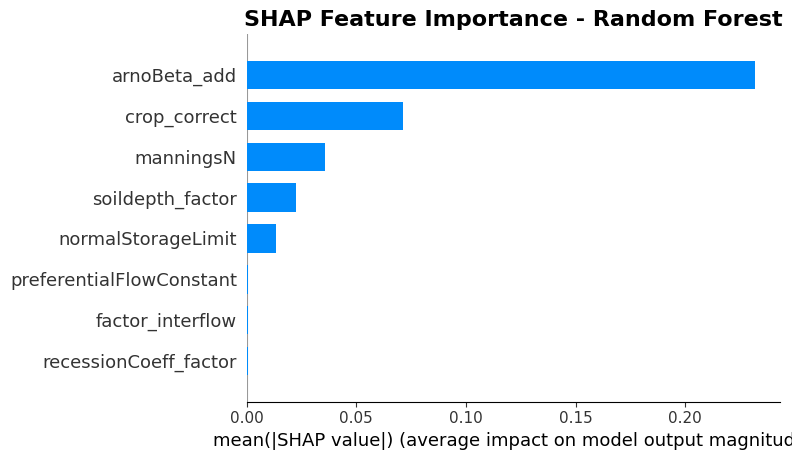

SHAP Feature Importance for Random Forest:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2316
0              crop_correct       0.0711
6                 manningsN       0.0355
1          soildepth_factor       0.0227
7        normalStorageLimit       0.0135
2  preferentialFlowConstant       0.0007
4          factor_interflow       0.0007
5     recessionCoeff_factor       0.0007
‚úÖ SHAP analysis completed for Random Forest

Generating SHAP analysis for Gradient Boosting...


SHAP Feature Importance for Gradient Boosting:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2228
0              crop_correct       0.0624
6                 manningsN       0.0414
1          soildepth_factor       0.0310
7        normalStorageLimit       0.0173
2  preferentialFlowConstant       0.0004
4          factor_interflow       0.0002
5     recessionCoeff_factor       0.0002
‚úÖ SHAP analysis completed for Gradient Boosting

Generating SHAP analysis for Linear Regression...


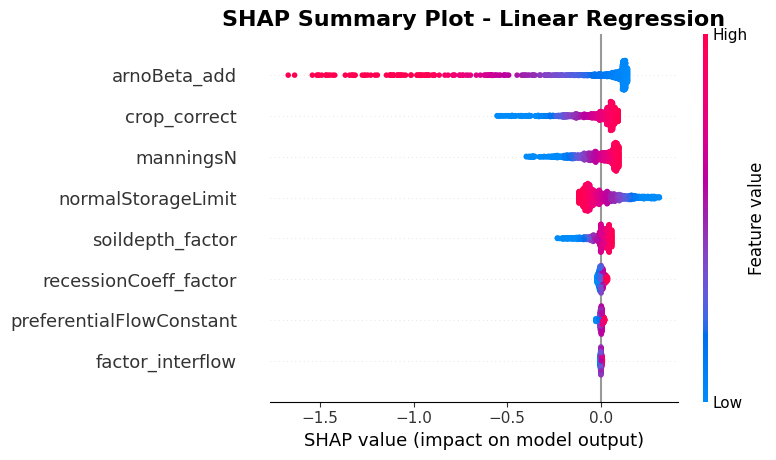

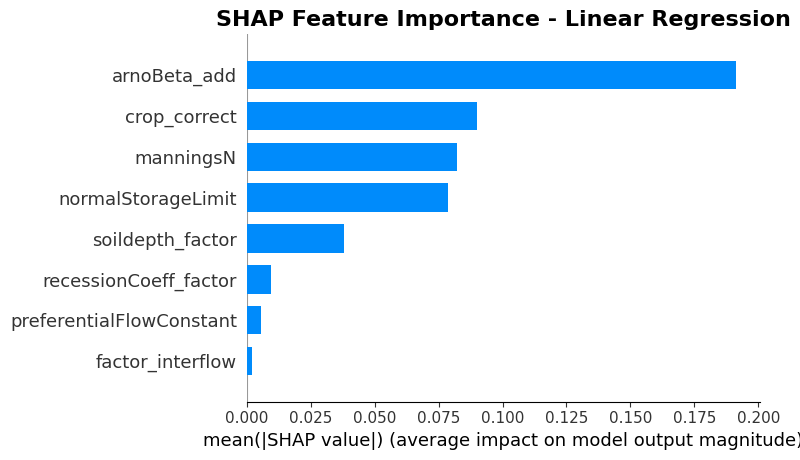

SHAP Feature Importance for Linear Regression:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.1912
0              crop_correct       0.0900
6                 manningsN       0.0824
7        normalStorageLimit       0.0786
1          soildepth_factor       0.0379
5     recessionCoeff_factor       0.0095
2  preferentialFlowConstant       0.0056
4          factor_interflow       0.0019
‚úÖ SHAP analysis completed for Linear Regression

Generating SHAP analysis for Ridge Regression...


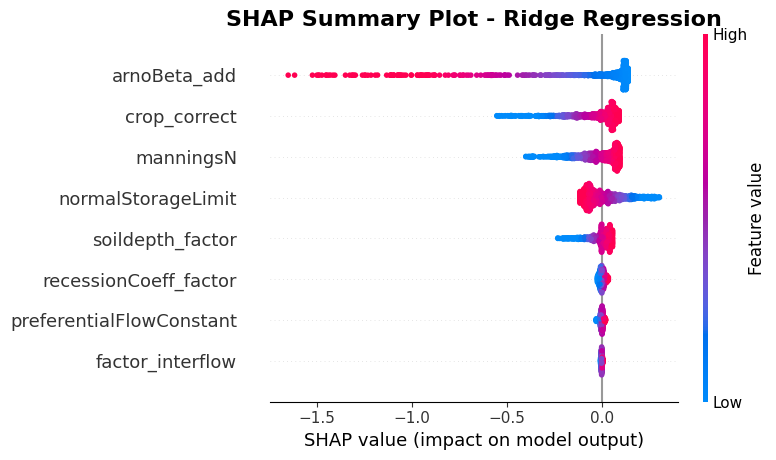

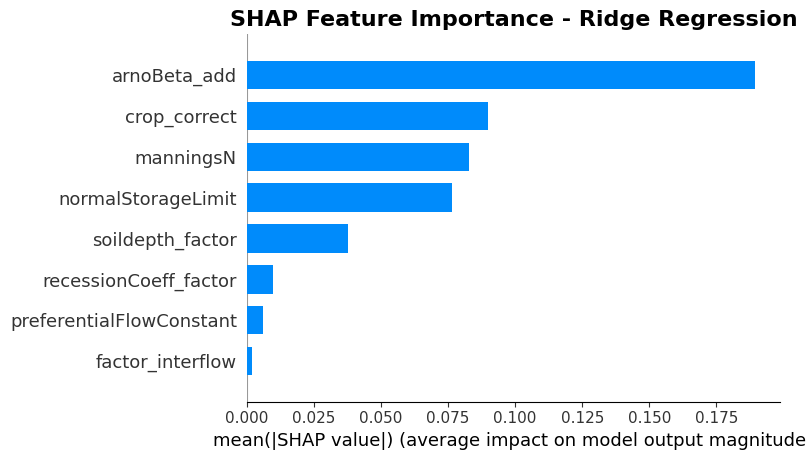

SHAP Feature Importance for Ridge Regression:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.1892
0              crop_correct       0.0898
6                 manningsN       0.0827
7        normalStorageLimit       0.0766
1          soildepth_factor       0.0377
5     recessionCoeff_factor       0.0096
2  preferentialFlowConstant       0.0059
4          factor_interflow       0.0019
‚úÖ SHAP analysis completed for Ridge Regression

PREDICTION ANALYSIS


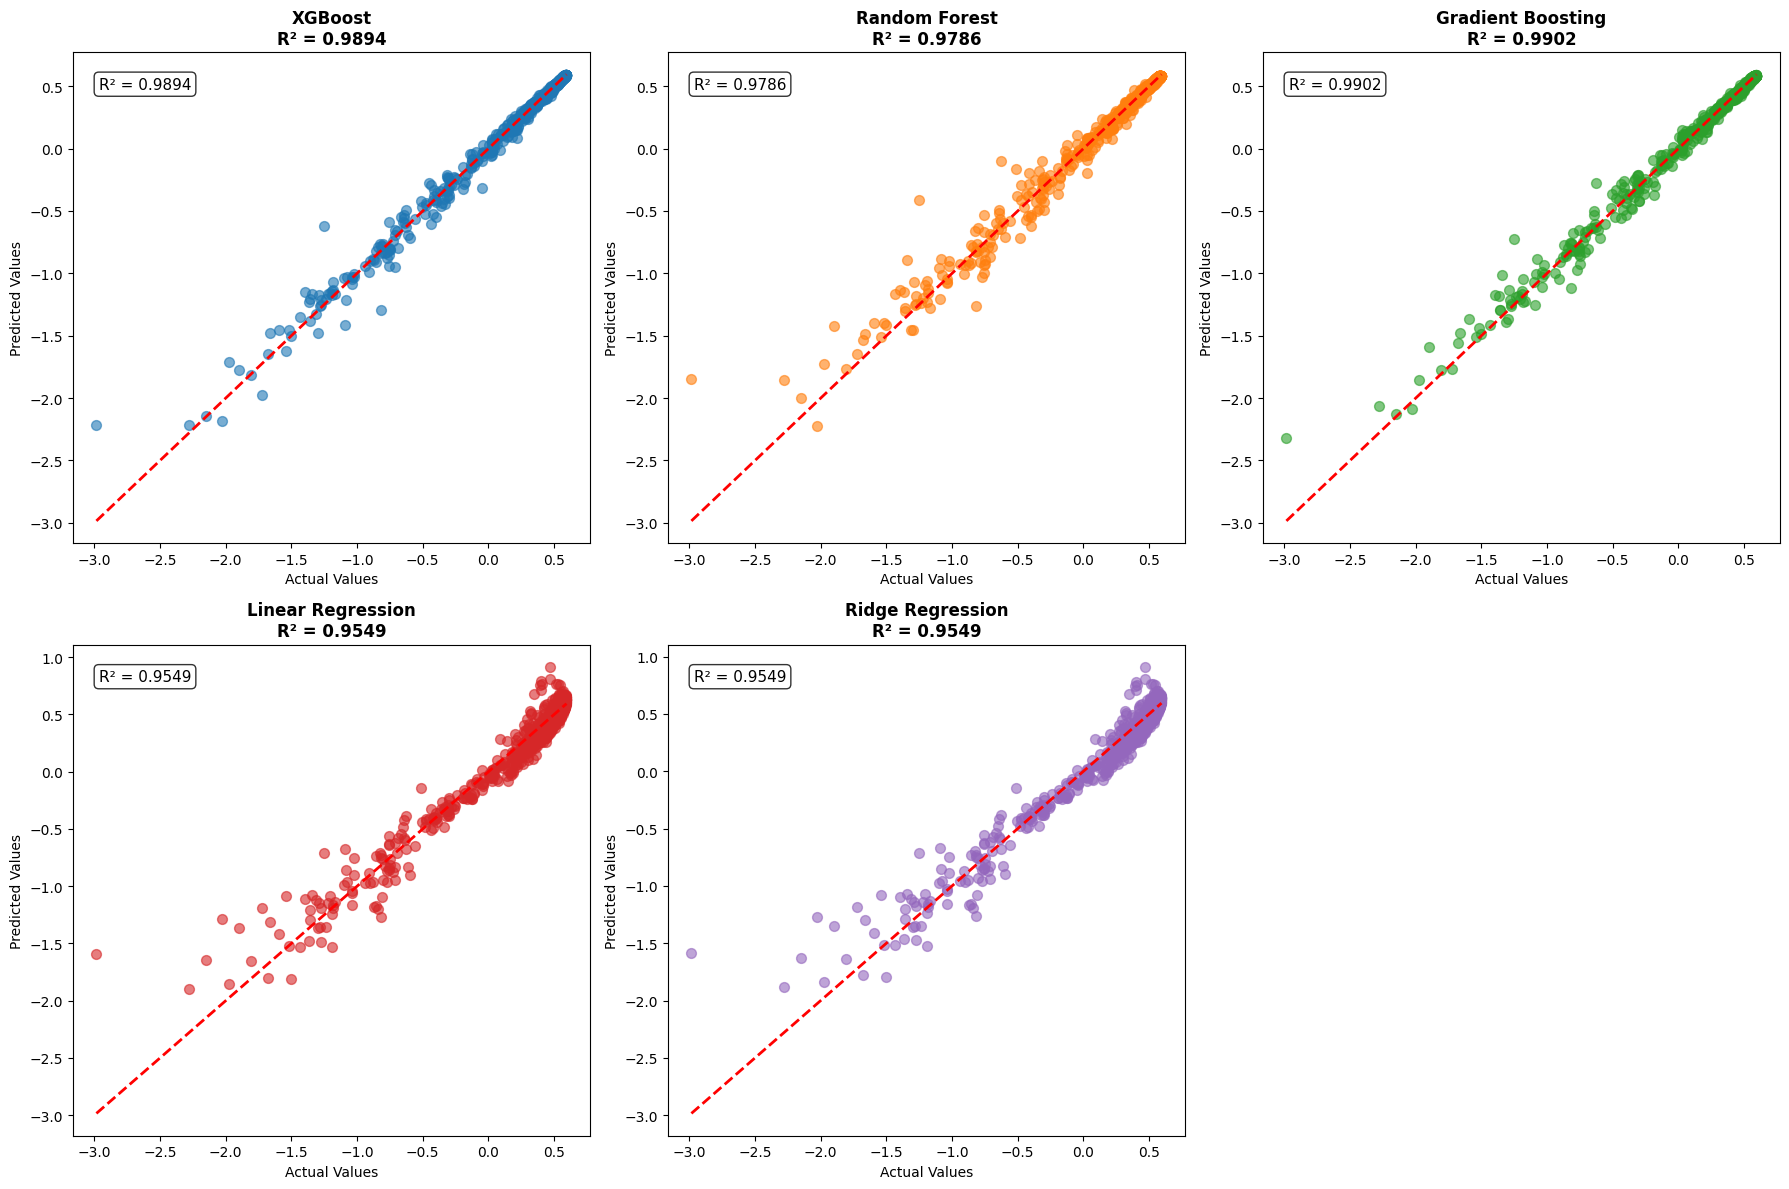


FEATURE RANKING ANALYSIS
Overall Feature Ranking (Average across all models):
                    Feature  Average_Importance
3              arnoBeta_add              1.2049
0              crop_correct              0.3057
7        normalStorageLimit              0.2578
1          soildepth_factor              0.1813
6                 manningsN              0.0614
2  preferentialFlowConstant              0.0031
5     recessionCoeff_factor              0.0029
4          factor_interflow              0.0026


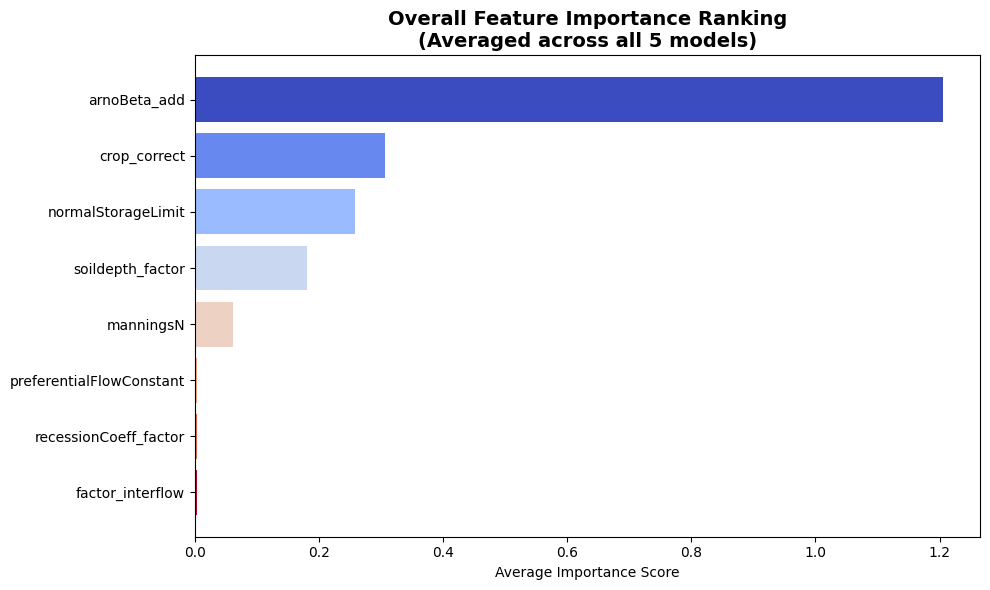


SAVING RESULTS
‚úÖ Results successfully saved to: H:\Work_with_MM\Model_Comparison_Results.xlsx

üìä Sheets created in the Excel file:
  - Original_Data: Original dataset
  - Model_Comparison: Performance metrics for all models
  - [Model]_Importance: Feature importance for tree-based models
  - [Model]_Coefficients: Coefficients for regression models
  - Predictions: Actual vs predicted values for test set
  - Overall_Feature_Ranking: Combined feature ranking
  - [Model]_SHAP_Values: SHAP values for each model

FINAL REPORT
üèÜ Best model: Gradient Boosting (Test R¬≤: 0.9902)

üìà Model Performance Ranking (by Test R¬≤):
ü•á 1. Gradient Boosting: R¬≤ = 0.9902, RMSE = 0.0477
ü•à 2. XGBoost: R¬≤ = 0.9894, RMSE = 0.0498
ü•â 3. Random Forest: R¬≤ = 0.9786, RMSE = 0.0708
   4. Linear Regression: R¬≤ = 0.9549, RMSE = 0.1026
   5. Ridge Regression: R¬≤ = 0.9549, RMSE = 0.1026

‚úÖ Analysis completed!
üìÅ Results saved to: H:\Work_with_MM\Model_Comparison_Results.xlsx
ü§ñ 5 models tr

In [3]:
import os
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------- 1. ÿÆŸàÿßŸÜÿØŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ŸÅÿß€åŸÑ ÿß⁄©ÿ≥ŸÑ ----------
excel_file = r"H:\Work_with_MM\KGE_7Prameters.xlsx"

try:
    # ÿÆŸàÿßŸÜÿØŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ŸÅÿß€åŸÑ ÿß⁄©ÿ≥ŸÑ
    df = pd.read_excel(excel_file)
    print("Data loaded successfully from Excel file")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿßÿÆÿ™ÿßÿ± ÿØÿßÿØŸá‚ÄåŸáÿß
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # ÿ¨ÿØÿß ⁄©ÿ±ÿØŸÜ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß (X) Ÿà ŸáÿØŸÅ (y)
    if 'KGE' in df.columns:
        y = df['KGE'].values
        X = df.drop('KGE', axis=1)
    else:
        # ÿß⁄Øÿ± ÿ≥ÿ™ŸàŸÜ KGE Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØÿå ŸÅÿ±ÿ∂ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿ¢ÿÆÿ±€åŸÜ ÿ≥ÿ™ŸàŸÜ ŸáÿØŸÅ ÿßÿ≥ÿ™
        y = df.iloc[:, -1].values
        X = df.iloc[:, :-1]
    
    # ÿ≠ÿ∞ŸÅ ÿ≥ÿ™ŸàŸÜ‚ÄåŸáÿß€å ÿ∫€åÿ±ÿπÿØÿØ€å (ŸÖÿßŸÜŸÜÿØ ŸÜÿßŸÖ ÿ±ÿßŸÜ)
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_columns]
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Features: {X.columns.tolist()}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    exit()

# ---------- 2. ÿ™ŸÇÿ≥€åŸÖ ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®Ÿá train Ÿà test ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ---------- 3. ÿ™ÿπÿ±€åŸÅ 5 ŸÖÿØŸÑ ----------
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42)
}

# ---------- 4. ÿ¢ŸÖŸàÿ≤ÿ¥ ŸÖÿØŸÑ‚ÄåŸáÿß Ÿà ÿßÿ±ÿ≤€åÿßÿ®€å ----------
results = {}
trained_models = {}

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # ÿ¢ŸÖŸàÿ≤ÿ¥ ŸÖÿØŸÑ
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖÿπ€åÿßÿ±Ÿáÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'model': model
    }
    
    print(f"{name}:")
    print(f"  Train R¬≤: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"  Test R¬≤:  {test_r2:.4f}, Test RMSE:  {test_rmse:.4f}")

# ---------- 5. ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_R2': [results[name]['train_r2'] for name in results],
    'Test_R2': [results[name]['test_r2'] for name in results],
    'Train_RMSE': [results[name]['train_rmse'] for name in results],
    'Test_RMSE': [results[name]['test_rmse'] for name in results]
})

print(comparison_df.round(4))

# ŸÜŸÖŸàÿØÿßÿ± ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß - ÿß€åÿ¨ÿßÿØ ÿØŸà ŸÜŸÖŸàÿØÿßÿ± ÿ¨ÿØÿß⁄ØÿßŸÜŸá
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# R¬≤ scores
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Train_R2'], alpha=0.7, label='Train R¬≤', color=colors)
bars2 = ax1.bar(comparison_df['Model'], comparison_df['Test_R2'], alpha=0.7, label='Test R¬≤', color=colors)
ax1.set_title('R¬≤ Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('R¬≤ Score')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿ±Ÿà€å ŸÜŸÖŸàÿØÿßÿ±
for bar, value in zip(bars1, comparison_df['Train_R2']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=9)

# RMSE scores
bars3 = ax2.bar(comparison_df['Model'], comparison_df['Train_RMSE'], alpha=0.7, label='Train RMSE', color=colors)
bars4 = ax2.bar(comparison_df['Model'], comparison_df['Test_RMSE'], alpha=0.7, label='Test RMSE', color=colors)
ax2.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ŸÜŸÖŸàÿØÿßÿ± ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
axes2 = axes2.ravel()

# ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å
tree_models = ['XGBoost', 'Random Forest', 'Gradient Boosting']
for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            axes2[i].barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                         color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))
            axes2[i].set_title(f'Feature Importance - {model_name}', fontsize=12, fontweight='bold')
            axes2[i].set_xlabel('Importance')

# ÿ∂ÿ±ÿß€åÿ® ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ ÿÆÿ∑€å Ÿà Ridge
regression_models = ['Linear Regression', 'Ridge Regression']
for i, model_name in enumerate(regression_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        coefficients = pd.DataFrame({
            'feature': X.columns,
            'coefficient': model.coef_
        }).sort_values('coefficient', key=abs, ascending=True)
        
        axes2[3+i].barh(coefficients['feature'], coefficients['coefficient'], 
                       color=plt.cm.plasma(np.linspace(0, 1, len(coefficients))))
        axes2[3+i].set_title(f'{model_name} Coefficients', fontsize=12, fontweight='bold')
        axes2[3+i].set_xlabel('Coefficient Value')
        axes2[3+i].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# ÿ≠ÿ∞ŸÅ ŸÖÿ≠Ÿàÿ± ÿßÿ∂ÿßŸÅ€å
axes2[5].set_visible(False)

plt.tight_layout()
plt.show()

# ---------- 6. ÿ™ÿ≠ŸÑ€åŸÑ SHAP ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# ÿß€åÿ¨ÿßÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å SHAP ÿ®ÿ±ÿß€å Ÿáÿ± ŸÖÿØŸÑ
for name, model in trained_models.items():
    print(f"\nGenerating SHAP analysis for {name}...")
    
    try:
        # ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ SHAP ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
        if name in ['Linear Regression', 'Ridge Regression']:
            # ÿ®ÿ±ÿß€å ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ ÿÆÿ∑€å ÿßÿ≤ LinearExplainer ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
            explainer = shap.LinearExplainer(model, X_train)
            shap_values = explainer.shap_values(X_test)
        else:
            # ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å ÿßÿ≤ TreeExplainer ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        
        # ŸÜŸÖŸàÿØÿßÿ± ÿÆŸÑÿßÿµŸá SHAP
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # ŸÜŸÖŸàÿØÿßÿ± ÿ®ÿßÿ± (bar plot)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ŸÖŸÇÿßÿØ€åÿ± ŸÖÿ∑ŸÑŸÇ SHAP
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Mean |SHAP|': mean_abs_shap
        }).sort_values('Mean |SHAP|', ascending=False)
        
        print(f"SHAP Feature Importance for {name}:")
        print(shap_importance_df.round(4))
        
        print(f"‚úÖ SHAP analysis completed for {name}")
        
    except Exception as e:
        print(f"‚ùå Error in SHAP analysis for {name}: {e}")

# ---------- 7. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)

# ŸÜŸÖŸàÿØÿßÿ± Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß ÿØÿ± ŸÖŸÇÿßÿ®ŸÑ ŸÖŸÇÿßÿØ€åÿ± ŸàÿßŸÇÿπ€å
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    if idx < len(axes):
        y_pred = model.predict(X_test)
        
        axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f'{name}\nR¬≤ = {results[name]["test_r2"]:.4f}', fontweight='bold')
        
        # ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ÿÆÿ∑ R¬≤ ÿ®Ÿá ŸÜŸÖŸàÿØÿßÿ±
        axes[idx].text(0.05, 0.95, f'R¬≤ = {results[name]["test_r2"]:.4f}', 
                      transform=axes[idx].transAxes, fontsize=11,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ÿ≠ÿ∞ŸÅ ŸÖÿ≠Ÿàÿ±Ÿáÿß€å ÿßÿ∂ÿßŸÅ€å
for idx in range(len(trained_models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# ---------- 8. ÿ™ÿ≠ŸÑ€åŸÑ ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("FEATURE RANKING ANALYSIS")
print("="*50)

# ÿ™ÿ±⁄©€åÿ® ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿßÿ≤ ÿ™ŸÖÿßŸÖ ŸÖÿØŸÑ‚ÄåŸáÿß
feature_ranking = {}

for name, model in trained_models.items():
    if name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            for i, feature in enumerate(X.columns):
                if feature not in feature_ranking:
                    feature_ranking[feature] = []
                feature_ranking[feature].append(importance[i])
    elif name in ['Linear Regression', 'Ridge Regression']:
        coefficients = np.abs(model.coef_)
        for i, feature in enumerate(X.columns):
            if feature not in feature_ranking:
                feature_ranking[feature] = []
            feature_ranking[feature].append(coefficients[i])

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ±ÿ™ÿ®Ÿá
feature_avg_importance = {}
for feature, importances in feature_ranking.items():
    feature_avg_importance[feature] = np.mean(importances)

# ÿß€åÿ¨ÿßÿØ ÿØ€åÿ™ÿßŸÅÿ±€åŸÖ ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å
feature_rank_df = pd.DataFrame({
    'Feature': list(feature_avg_importance.keys()),
    'Average_Importance': list(feature_avg_importance.values())
}).sort_values('Average_Importance', ascending=False)

print("Overall Feature Ranking (Average across all models):")
print(feature_rank_df.round(4))

# ŸÜŸÖŸàÿØÿßÿ± ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å ⁄©ŸÑ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
plt.figure(figsize=(10, 6))
plt.barh(feature_rank_df['Feature'], feature_rank_df['Average_Importance'], 
         color=plt.cm.coolwarm(np.linspace(0, 1, len(feature_rank_df))))
plt.xlabel('Average Importance Score')
plt.title('Overall Feature Importance Ranking\n(Averaged across all 5 models)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- 9. ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ----------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

output_file = r"H:\Work_with_MM\Model_Comparison_Results.xlsx"

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿßÿµŸÑ€å
        df.to_excel(writer, sheet_name='Original_Data', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß
        comparison_df.to_excel(writer, sheet_name='Model_Comparison', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å
        for model_name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
            if model_name in trained_models and hasattr(trained_models[model_name], 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': trained_models[model_name].feature_importances_
                }).sort_values('Importance', ascending=False)
                importance_df.to_excel(writer, sheet_name=f'{model_name}_Importance', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ
        for model_name in ['Linear Regression', 'Ridge Regression']:
            if model_name in trained_models:
                coeff_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Coefficient': trained_models[model_name].coef_,
                    'Absolute_Coefficient': np.abs(trained_models[model_name].coef_)
                }).sort_values('Absolute_Coefficient', ascending=False)
                coeff_df.to_excel(writer, sheet_name=f'{model_name}_Coefficients', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß
        predictions_df = pd.DataFrame({
            'Actual': y_test
        })
        for name in trained_models:
            predictions_df[f'{name}_Predicted'] = trained_models[name].predict(X_test)
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å ⁄©ŸÑ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
        feature_rank_df.to_excel(writer, sheet_name='Overall_Feature_Ranking', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸÖŸÇÿßÿØ€åÿ± SHAP
        for name in trained_models:
            try:
                if name in ['Linear Regression', 'Ridge Regression']:
                    explainer = shap.LinearExplainer(trained_models[name], X_train)
                    shap_values = explainer.shap_values(X_test)
                else:
                    explainer = shap.TreeExplainer(trained_models[name])
                    shap_values = explainer.shap_values(X_test)
                
                shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X.columns])
                shap_df.to_excel(writer, sheet_name=f'{name}_SHAP_Values', index=False)
                
            except Exception as e:
                print(f"Could not save SHAP values for {name}: {e}")
    
    print(f"‚úÖ Results successfully saved to: {output_file}")
    print("\nüìä Sheets created in the Excel file:")
    print("  - Original_Data: Original dataset")
    print("  - Model_Comparison: Performance metrics for all models")
    print("  - [Model]_Importance: Feature importance for tree-based models")
    print("  - [Model]_Coefficients: Coefficients for regression models")
    print("  - Predictions: Actual vs predicted values for test set")
    print("  - Overall_Feature_Ranking: Combined feature ranking")
    print("  - [Model]_SHAP_Values: SHAP values for each model")
    
except Exception as e:
    print(f"‚ùå Error saving results to Excel: {e}")

# ---------- 10. ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ----------
print("\n" + "="*50)
print("FINAL REPORT")
print("="*50)

best_model = comparison_df.loc[comparison_df['Test_R2'].idxmax()]
print(f"üèÜ Best model: {best_model['Model']} (Test R¬≤: {best_model['Test_R2']:.4f})")

print("\nüìà Model Performance Ranking (by Test R¬≤):")
ranked_models = comparison_df.sort_values('Test_R2', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    medal = "ü•á" if i == 1 else "ü•à" if i == 2 else "ü•â" if i == 3 else "  "
    print(f"{medal} {i}. {row['Model']}: R¬≤ = {row['Test_R2']:.4f}, RMSE = {row['Test_RMSE']:.4f}")

print(f"\n‚úÖ Analysis completed!")
print(f"üìÅ Results saved to: {output_file}")
print(f"ü§ñ {len(trained_models)} models trained and evaluated")
print(f"üîç SHAP analysis generated for all models")
print(f"üìä Overall feature ranking calculated")

üìÅ Results directory created: SHAP_Result
Data loaded successfully from Excel file
Data shape: (5377, 10)
Columns: ['crop_correct', 'soildepth_factor', 'preferentialFlowConstant', 'arnoBeta_add', 'factor_interflow', 'recessionCoeff_factor', 'manningsN', 'normalStorageLimit', 'run_name', 'KGE']

First 5 rows of data:
   crop_correct  soildepth_factor  preferentialFlowConstant  arnoBeta_add  \
0      1.235751          1.281048                  6.859113      0.108474   
1      1.576541          0.875025                  4.500981      0.891433   
2      1.486260          1.291231                  5.768497      0.401101   
3      0.916324          1.317238                  7.205576      0.016206   
4      1.510463          1.222929                  2.038560      0.246717   

   factor_interflow  recessionCoeff_factor  manningsN  normalStorageLimit  \
0          1.086829               5.598648   7.436221            0.295064   
1          2.189699               9.337311   9.928568          

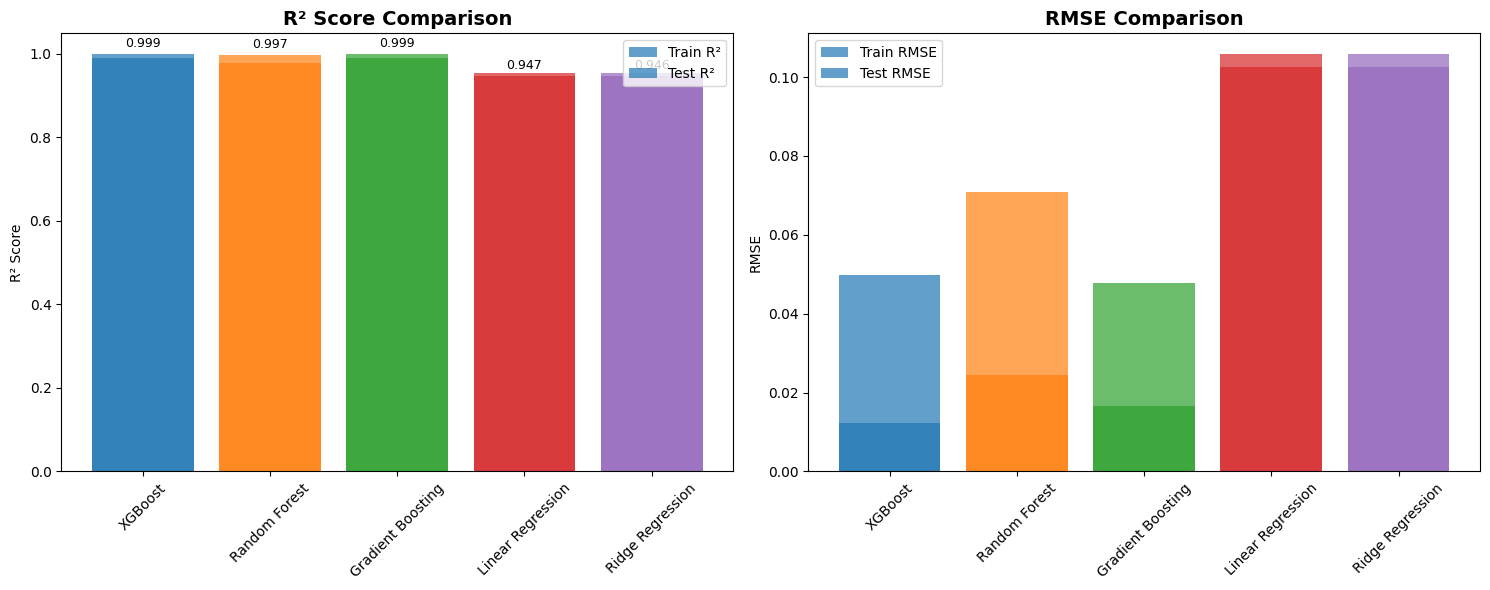

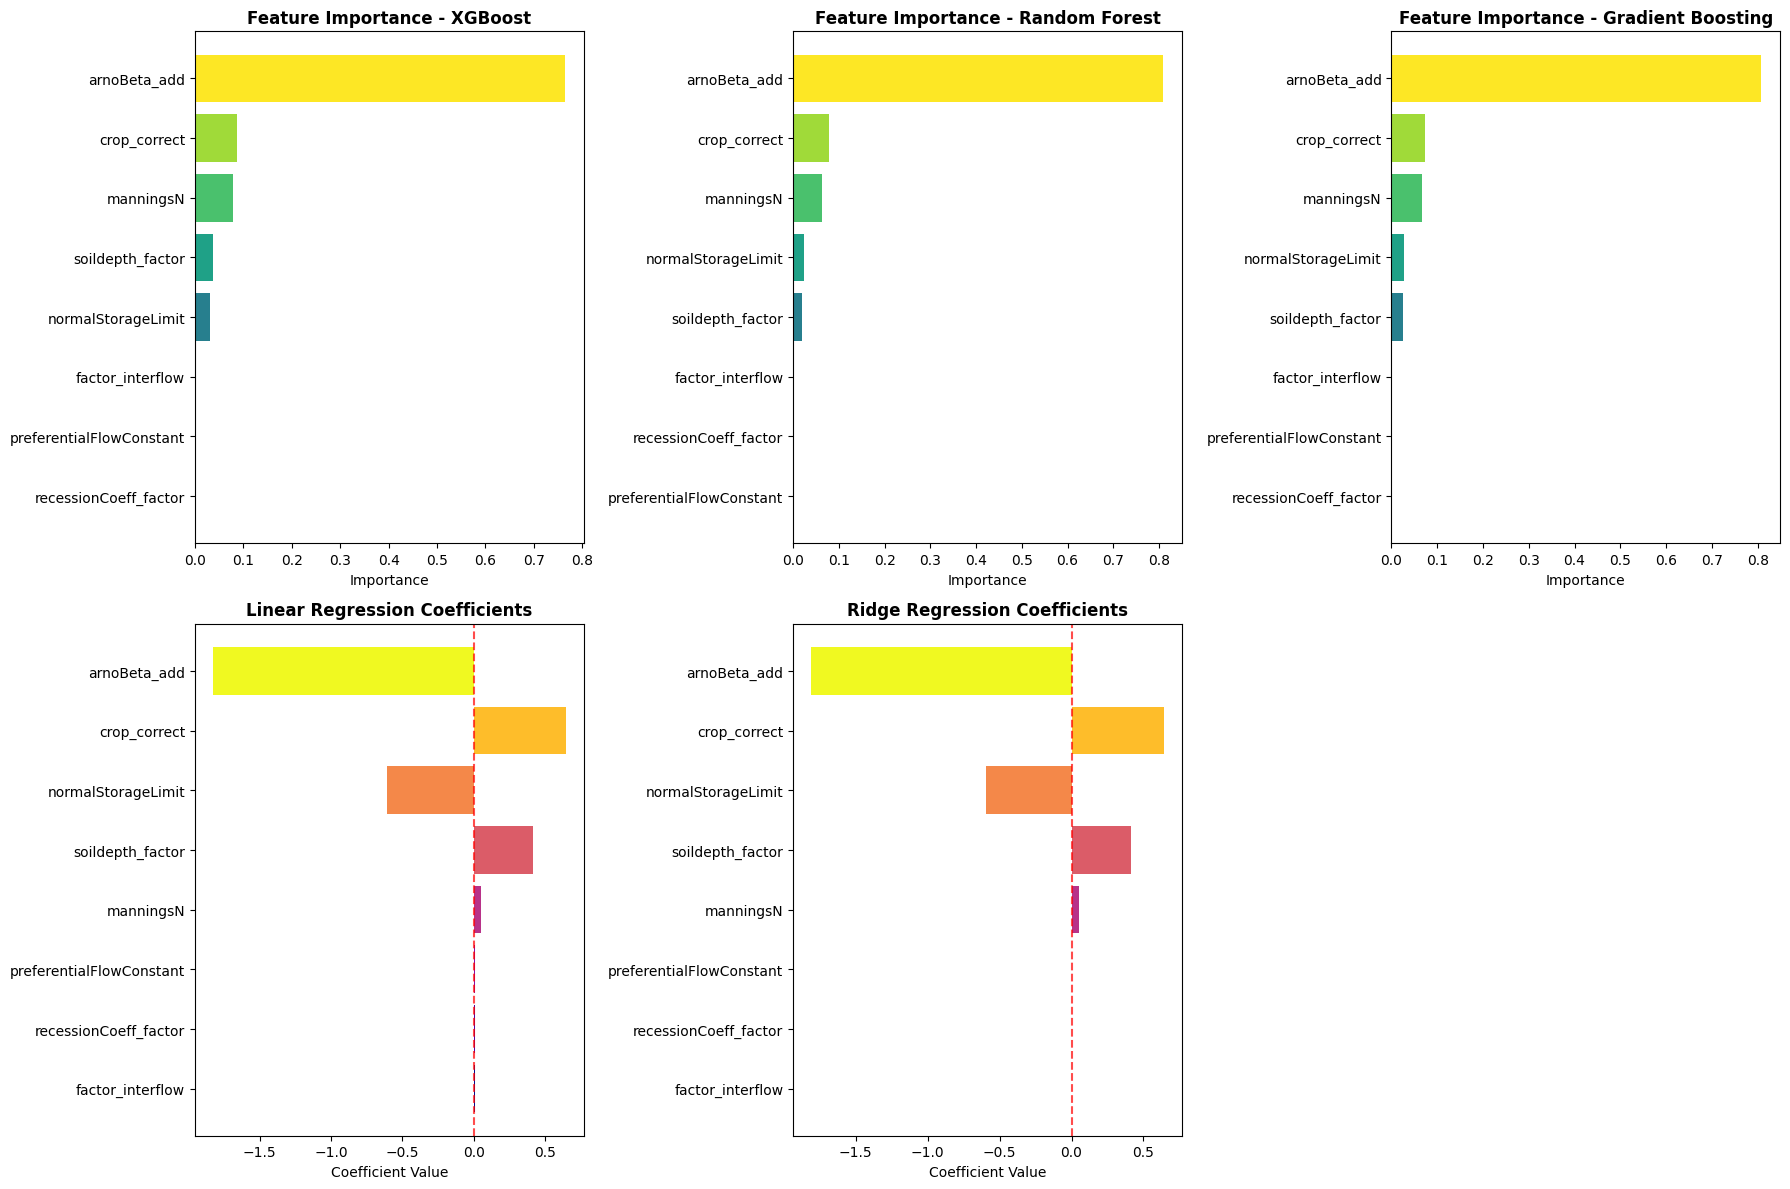


SHAP ANALYSIS

Generating SHAP analysis for XGBoost...


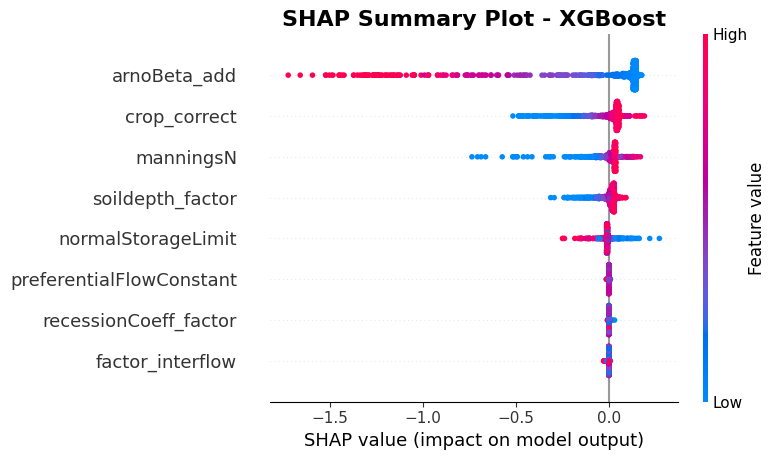

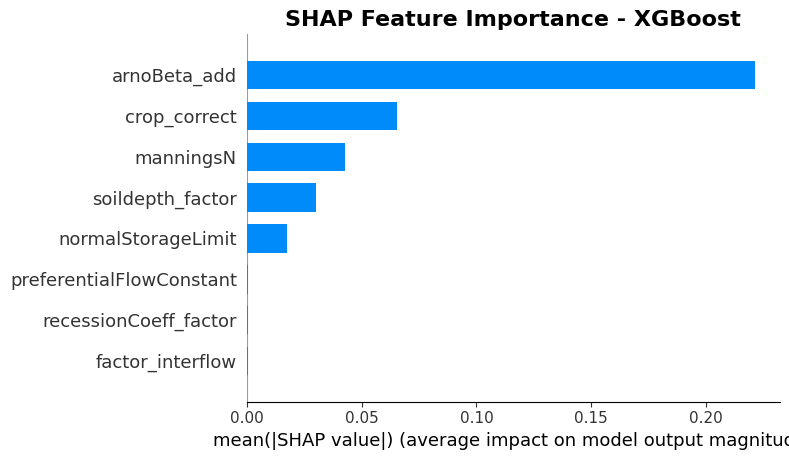

<Figure size 1000x600 with 0 Axes>

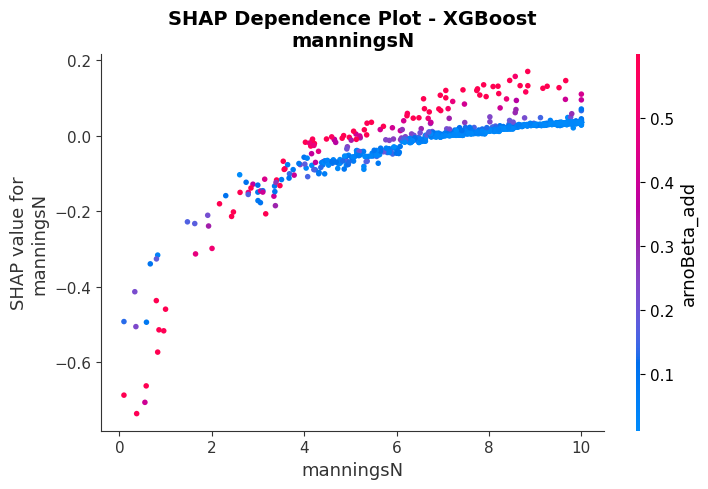

<Figure size 1000x600 with 0 Axes>

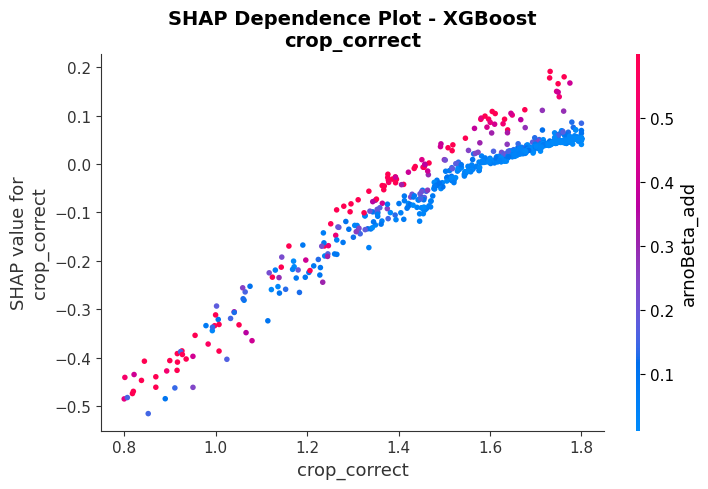

<Figure size 1000x600 with 0 Axes>

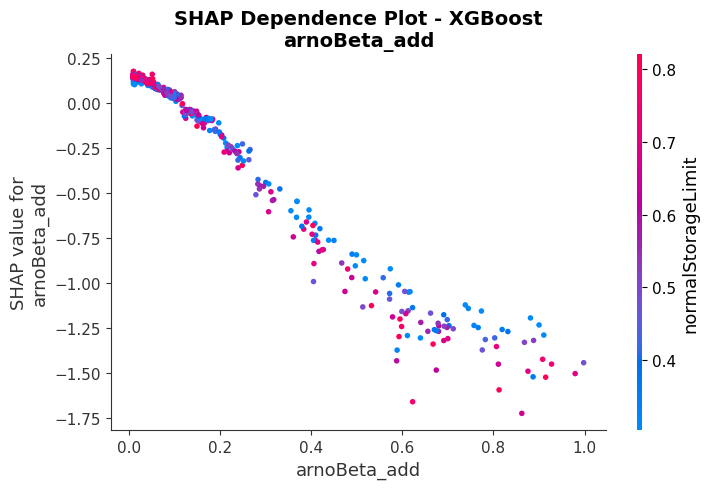

SHAP Feature Importance for XGBoost:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2211
0              crop_correct       0.0656
6                 manningsN       0.0426
1          soildepth_factor       0.0303
7        normalStorageLimit       0.0176
2  preferentialFlowConstant       0.0007
5     recessionCoeff_factor       0.0007
4          factor_interflow       0.0005
‚úÖ SHAP analysis completed for XGBoost

Generating SHAP analysis for Random Forest...


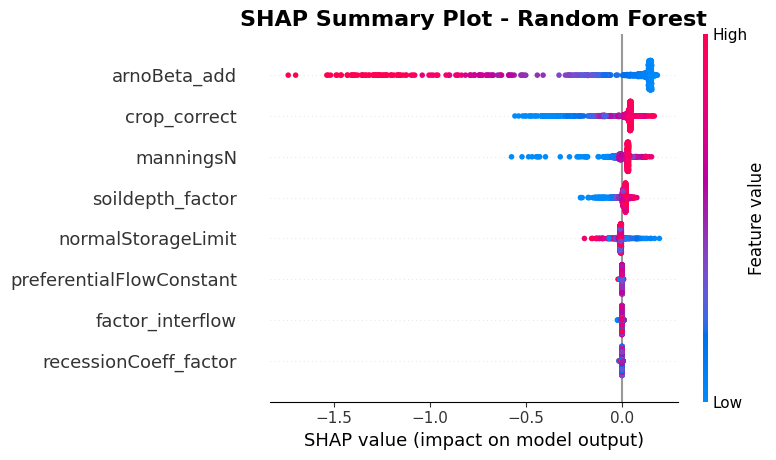

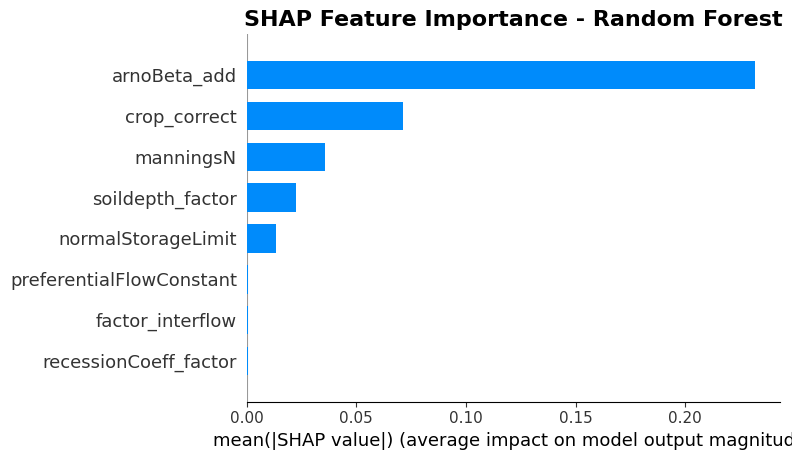

<Figure size 1000x600 with 0 Axes>

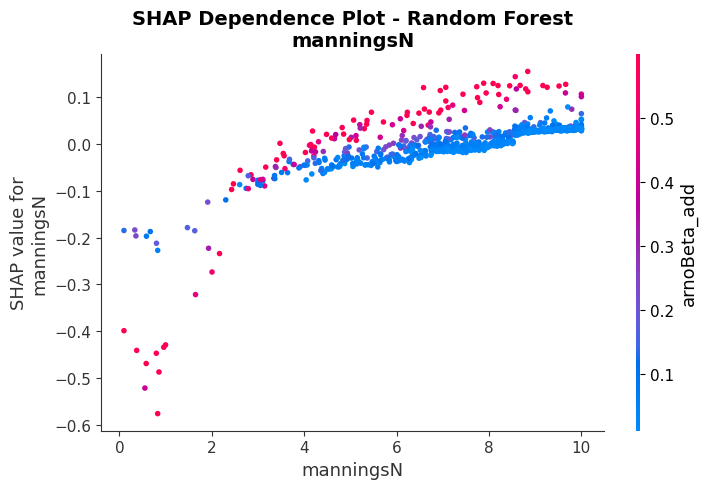

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

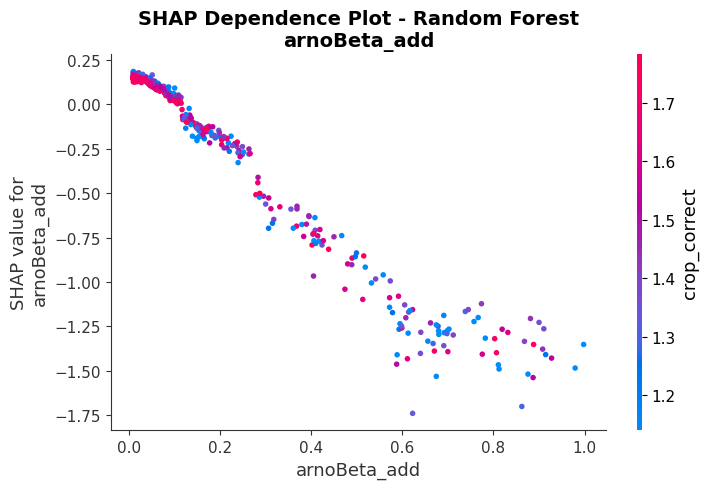

SHAP Feature Importance for Random Forest:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2316
0              crop_correct       0.0711
6                 manningsN       0.0355
1          soildepth_factor       0.0227
7        normalStorageLimit       0.0135
2  preferentialFlowConstant       0.0007
4          factor_interflow       0.0007
5     recessionCoeff_factor       0.0007
‚úÖ SHAP analysis completed for Random Forest

Generating SHAP analysis for Gradient Boosting...


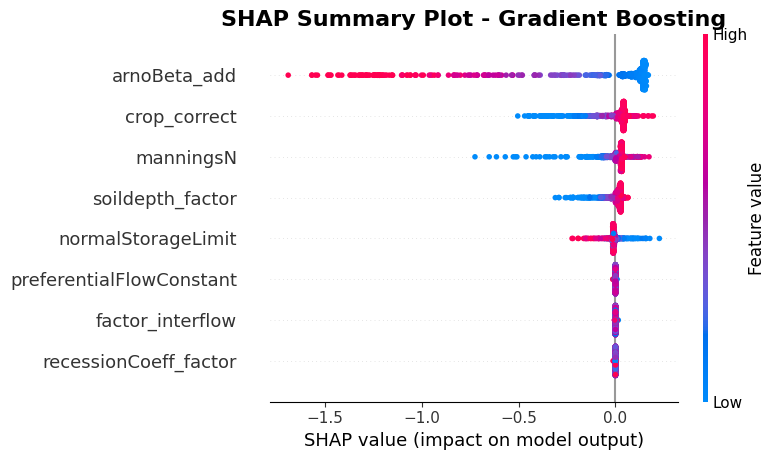

<Figure size 1000x600 with 0 Axes>

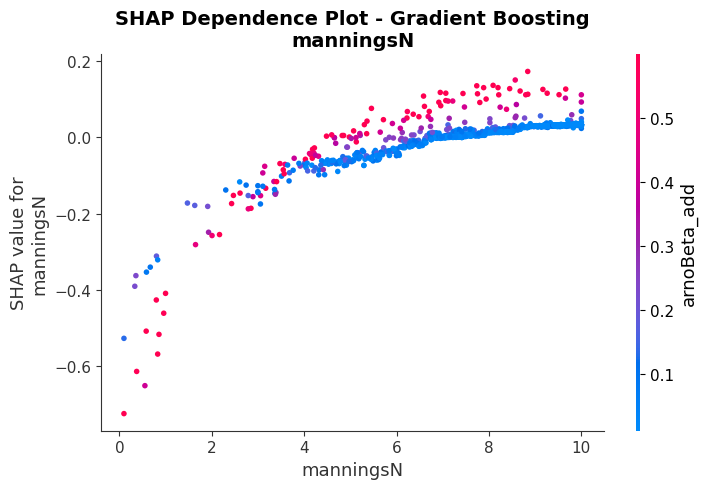

<Figure size 1000x600 with 0 Axes>

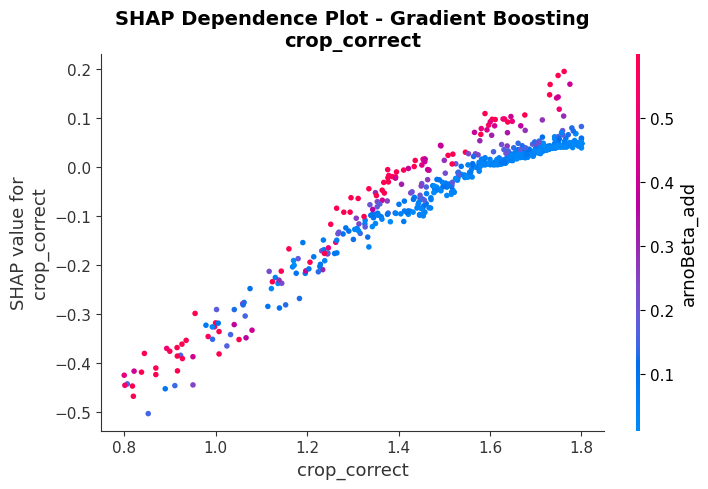

<Figure size 1000x600 with 0 Axes>

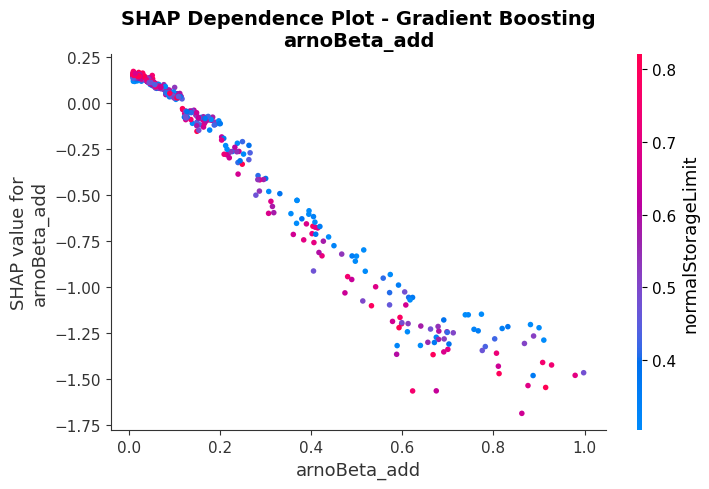

SHAP Feature Importance for Gradient Boosting:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.2228
0              crop_correct       0.0624
6                 manningsN       0.0414
1          soildepth_factor       0.0310
7        normalStorageLimit       0.0173
2  preferentialFlowConstant       0.0004
4          factor_interflow       0.0002
5     recessionCoeff_factor       0.0002
‚úÖ SHAP analysis completed for Gradient Boosting

Generating SHAP analysis for Linear Regression...


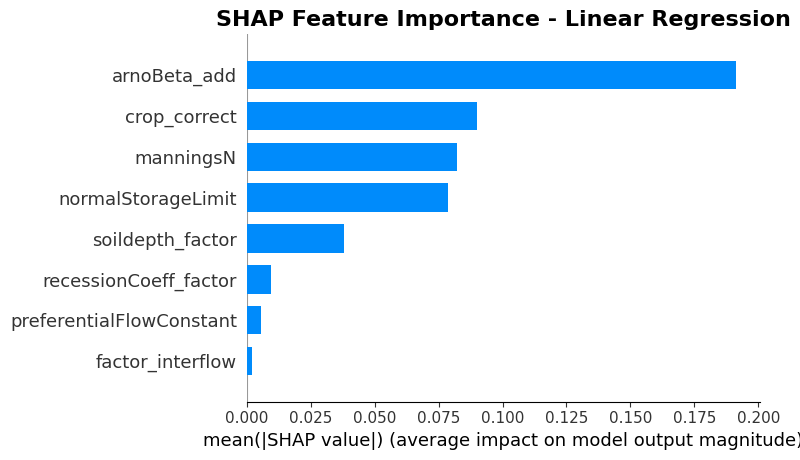

<Figure size 1000x600 with 0 Axes>

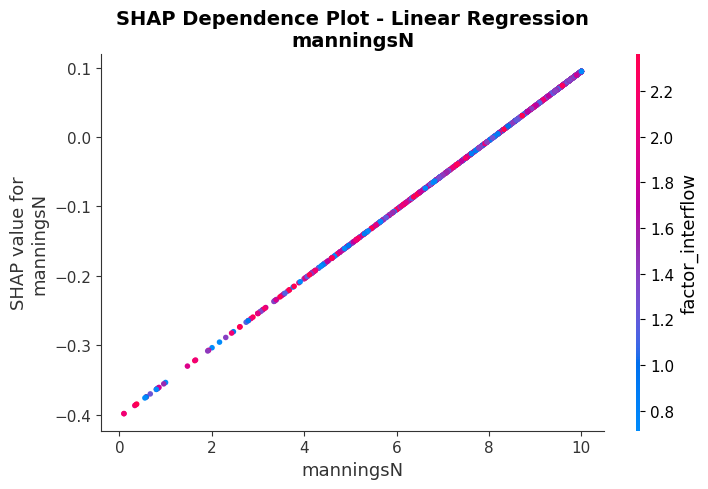

<Figure size 1000x600 with 0 Axes>

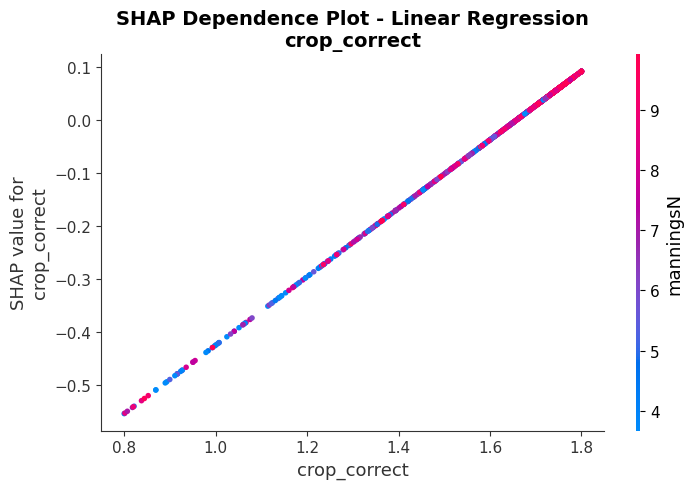

<Figure size 1000x600 with 0 Axes>

SHAP Feature Importance for Linear Regression:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.1912
0              crop_correct       0.0900
6                 manningsN       0.0824
7        normalStorageLimit       0.0786
1          soildepth_factor       0.0379
5     recessionCoeff_factor       0.0095
2  preferentialFlowConstant       0.0056
4          factor_interflow       0.0019
‚úÖ SHAP analysis completed for Linear Regression

Generating SHAP analysis for Ridge Regression...


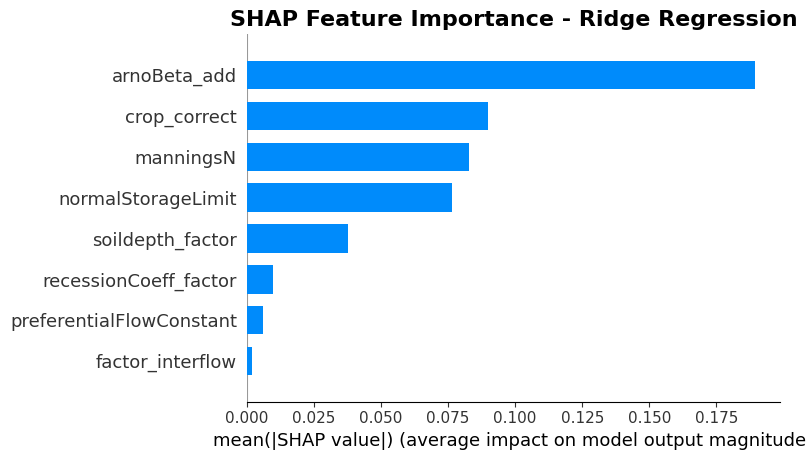

<Figure size 1000x600 with 0 Axes>

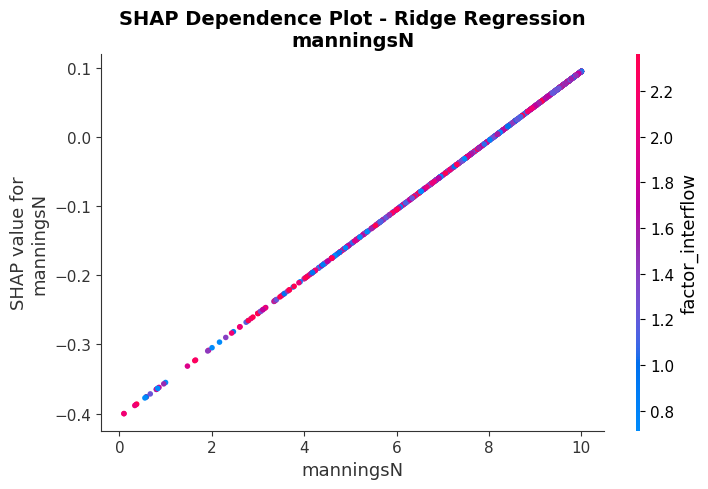

<Figure size 1000x600 with 0 Axes>

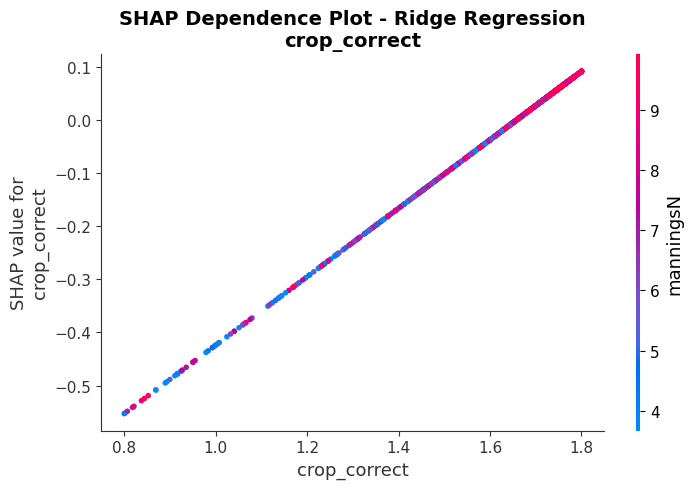

<Figure size 1000x600 with 0 Axes>

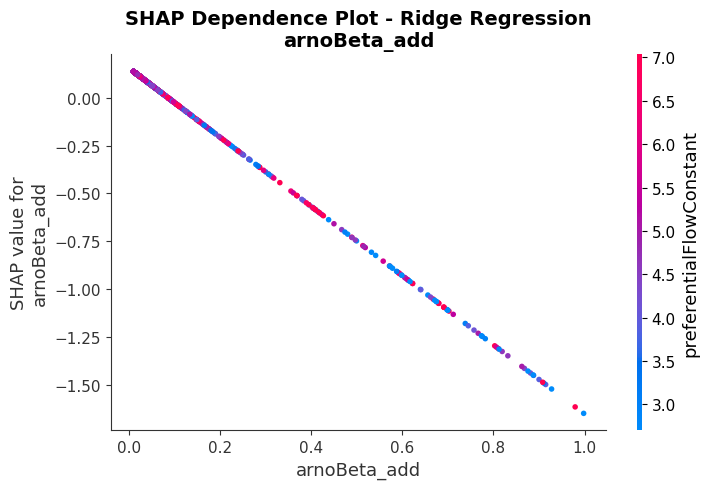

SHAP Feature Importance for Ridge Regression:
                    Feature  Mean |SHAP|
3              arnoBeta_add       0.1892
0              crop_correct       0.0898
6                 manningsN       0.0827
7        normalStorageLimit       0.0766
1          soildepth_factor       0.0377
5     recessionCoeff_factor       0.0096
2  preferentialFlowConstant       0.0059
4          factor_interflow       0.0019
‚úÖ SHAP analysis completed for Ridge Regression

PREDICTION ANALYSIS


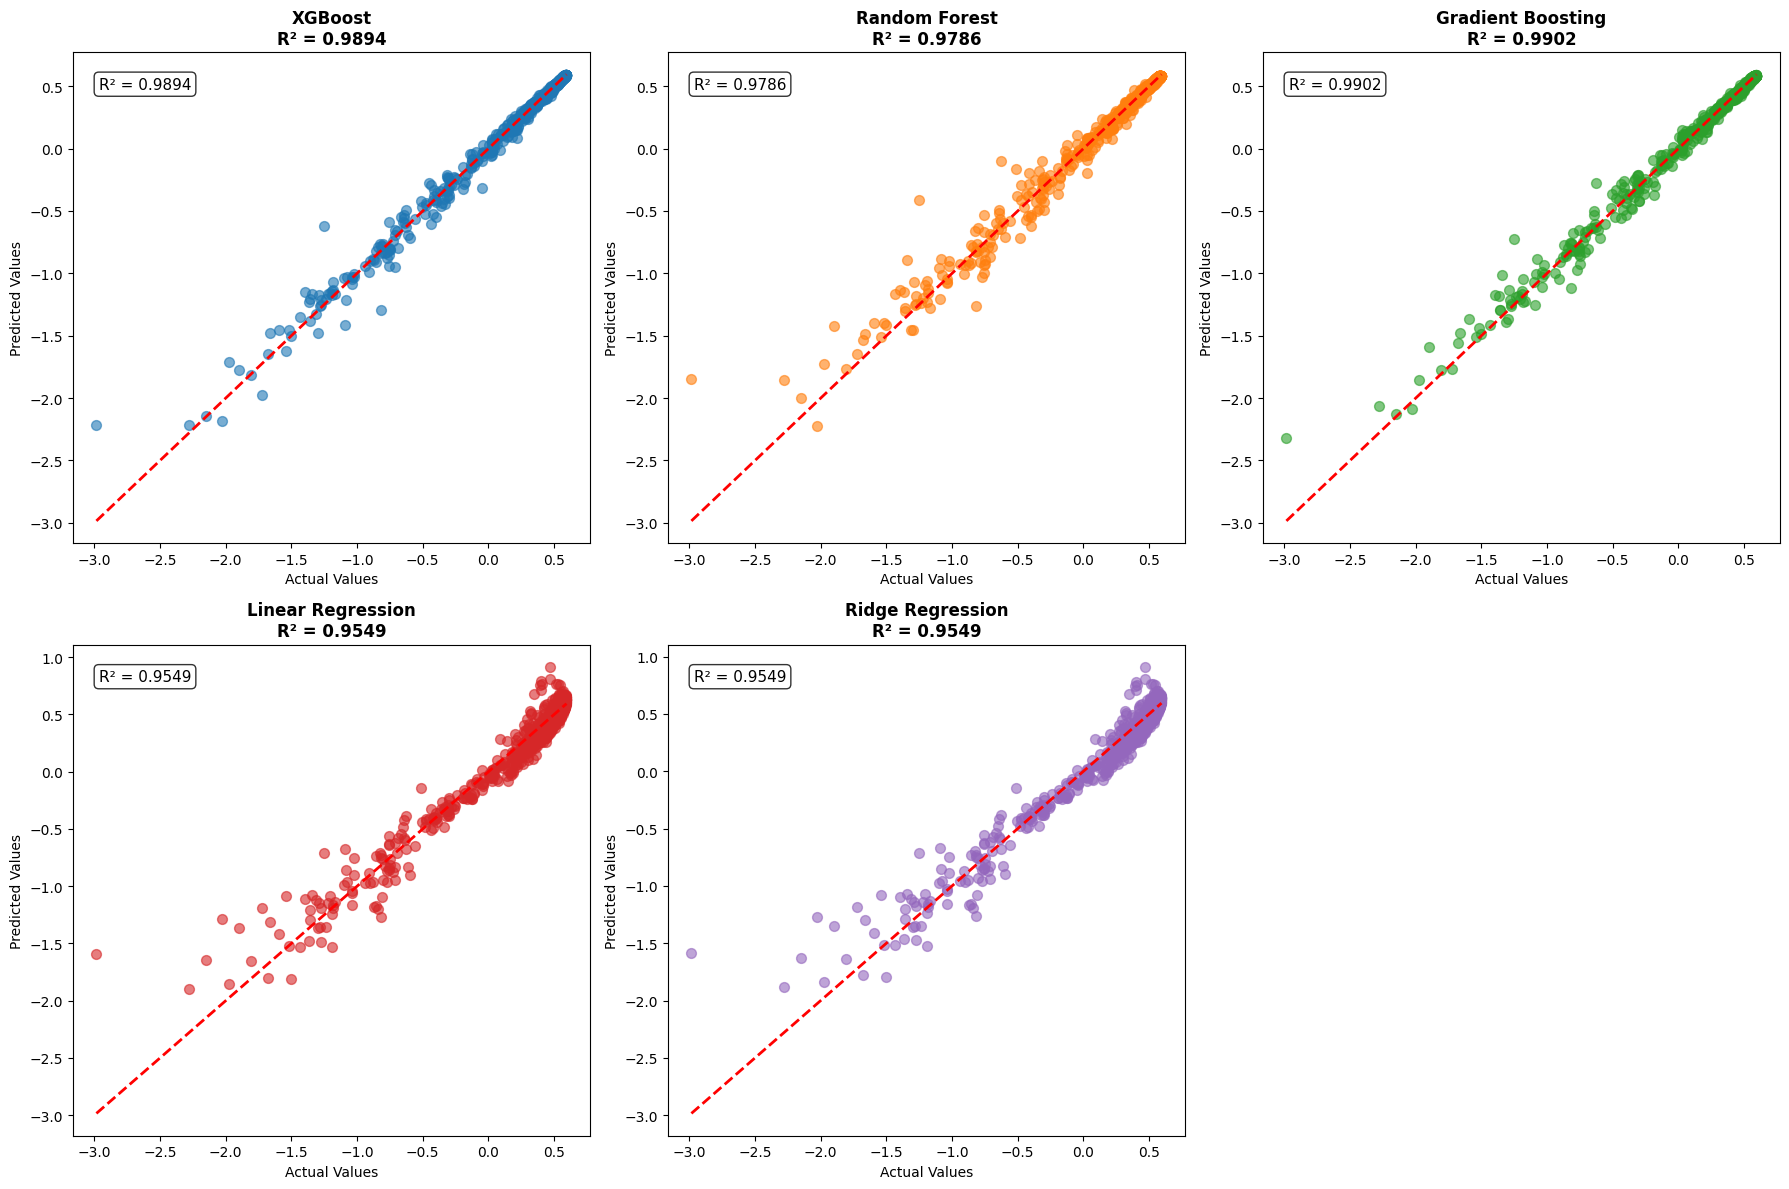


FEATURE RANKING ANALYSIS
Overall Feature Ranking (Average across all models):
                    Feature  Average_Importance
3              arnoBeta_add              1.2049
0              crop_correct              0.3057
7        normalStorageLimit              0.2578
1          soildepth_factor              0.1813
6                 manningsN              0.0614
2  preferentialFlowConstant              0.0031
5     recessionCoeff_factor              0.0029
4          factor_interflow              0.0026


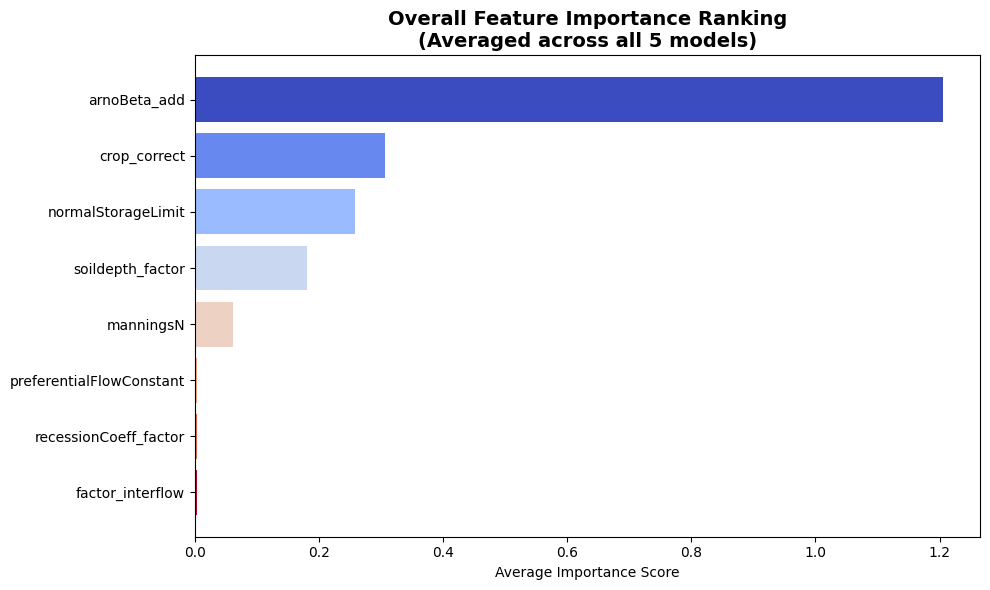


ADDITIONAL VISUALIZATIONS



SAVING RESULTS
‚úÖ Results successfully saved to: SHAP_Result\Model_Comparison_Results.xlsx

üìä Sheets created in the Excel file:
  - Original_Data: Original dataset
  - Model_Comparison: Performance metrics for all models
  - [Model]_Importance: Feature importance for tree-based models
  - [Model]_Coefficients: Coefficients for regression models
  - Predictions: Actual vs predicted values for test set
  - Overall_Feature_Ranking: Combined feature ranking
  - [Model]_SHAP_Values: SHAP values for each model

FINAL REPORT
üèÜ Best model: Gradient Boosting (Test R¬≤: 0.9902)

üìà Model Performance Ranking (by Test R¬≤):
ü•á 1. Gradient Boosting: R¬≤ = 0.9902, RMSE = 0.0477
ü•à 2. XGBoost: R¬≤ = 0.9894, RMSE = 0.0498
ü•â 3. Random Forest: R¬≤ = 0.9786, RMSE = 0.0708
   4. Linear Regression: R¬≤ = 0.9549, RMSE = 0.1026
   5. Ridge Regression: R¬≤ = 0.9549, RMSE = 0.1026

‚úÖ Analysis completed!
üìÅ Results directory: SHAP_Result
üìä Excel file: SHAP_Result\Model_Comparison_Results

In [4]:
import os
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------- ÿß€åÿ¨ÿßÿØ ŸæŸàÿ¥Ÿá ÿ®ÿ±ÿß€å ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ----------
results_dir = "SHAP_Result"
os.makedirs(results_dir, exist_ok=True)
print(f"üìÅ Results directory created: {results_dir}")

# ---------- 1. ÿÆŸàÿßŸÜÿØŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ŸÅÿß€åŸÑ ÿß⁄©ÿ≥ŸÑ ----------
excel_file = r"H:\Work_with_MM\KGE_7Prameters.xlsx"

try:
    # ÿÆŸàÿßŸÜÿØŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ÿßÿ≤ ŸÅÿß€åŸÑ ÿß⁄©ÿ≥ŸÑ
    df = pd.read_excel(excel_file)
    print("Data loaded successfully from Excel file")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿßÿÆÿ™ÿßÿ± ÿØÿßÿØŸá‚ÄåŸáÿß
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # ÿ¨ÿØÿß ⁄©ÿ±ÿØŸÜ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß (X) Ÿà ŸáÿØŸÅ (y)
    if 'KGE' in df.columns:
        y = df['KGE'].values
        X = df.drop('KGE', axis=1)
    else:
        # ÿß⁄Øÿ± ÿ≥ÿ™ŸàŸÜ KGE Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØÿå ŸÅÿ±ÿ∂ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿ¢ÿÆÿ±€åŸÜ ÿ≥ÿ™ŸàŸÜ ŸáÿØŸÅ ÿßÿ≥ÿ™
        y = df.iloc[:, -1].values
        X = df.iloc[:, :-1]
    
    # ÿ≠ÿ∞ŸÅ ÿ≥ÿ™ŸàŸÜ‚ÄåŸáÿß€å ÿ∫€åÿ±ÿπÿØÿØ€å (ŸÖÿßŸÜŸÜÿØ ŸÜÿßŸÖ ÿ±ÿßŸÜ)
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_columns]
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Features: {X.columns.tolist()}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    exit()

# ---------- 2. ÿ™ŸÇÿ≥€åŸÖ ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®Ÿá train Ÿà test ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ---------- 3. ÿ™ÿπÿ±€åŸÅ 5 ŸÖÿØŸÑ ----------
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42)
}

# ---------- 4. ÿ¢ŸÖŸàÿ≤ÿ¥ ŸÖÿØŸÑ‚ÄåŸáÿß Ÿà ÿßÿ±ÿ≤€åÿßÿ®€å ----------
results = {}
trained_models = {}

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # ÿ¢ŸÖŸàÿ≤ÿ¥ ŸÖÿØŸÑ
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖÿπ€åÿßÿ±Ÿáÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'model': model
    }
    
    print(f"{name}:")
    print(f"  Train R¬≤: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"  Test R¬≤:  {test_r2:.4f}, Test RMSE:  {test_rmse:.4f}")

# ---------- 5. ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_R2': [results[name]['train_r2'] for name in results],
    'Test_R2': [results[name]['test_r2'] for name in results],
    'Train_RMSE': [results[name]['train_rmse'] for name in results],
    'Test_RMSE': [results[name]['test_rmse'] for name in results]
})

print(comparison_df.round(4))

# ŸÜŸÖŸàÿØÿßÿ± ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß - ÿß€åÿ¨ÿßÿØ ÿØŸà ŸÜŸÖŸàÿØÿßÿ± ÿ¨ÿØÿß⁄ØÿßŸÜŸá
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# R¬≤ scores
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Train_R2'], alpha=0.7, label='Train R¬≤', color=colors)
bars2 = ax1.bar(comparison_df['Model'], comparison_df['Test_R2'], alpha=0.7, label='Test R¬≤', color=colors)
ax1.set_title('R¬≤ Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('R¬≤ Score')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿ±Ÿà€å ŸÜŸÖŸàÿØÿßÿ±
for bar, value in zip(bars1, comparison_df['Train_R2']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=9)

# RMSE scores
bars3 = ax2.bar(comparison_df['Model'], comparison_df['Train_RMSE'], alpha=0.7, label='Train RMSE', color=colors)
bars4 = ax2.bar(comparison_df['Model'], comparison_df['Test_RMSE'], alpha=0.7, label='Test RMSE', color=colors)
ax2.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '01_Model_Performance_Comparison.png'), dpi=500, bbox_inches='tight')
plt.show()

# ŸÜŸÖŸàÿØÿßÿ± ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
axes2 = axes2.ravel()

# ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å
tree_models = ['XGBoost', 'Random Forest', 'Gradient Boosting']
for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            axes2[i].barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                         color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))
            axes2[i].set_title(f'Feature Importance - {model_name}', fontsize=12, fontweight='bold')
            axes2[i].set_xlabel('Importance')

# ÿ∂ÿ±ÿß€åÿ® ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ ÿÆÿ∑€å Ÿà Ridge
regression_models = ['Linear Regression', 'Ridge Regression']
for i, model_name in enumerate(regression_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        coefficients = pd.DataFrame({
            'feature': X.columns,
            'coefficient': model.coef_
        }).sort_values('coefficient', key=abs, ascending=True)
        
        axes2[3+i].barh(coefficients['feature'], coefficients['coefficient'], 
                       color=plt.cm.plasma(np.linspace(0, 1, len(coefficients))))
        axes2[3+i].set_title(f'{model_name} Coefficients', fontsize=12, fontweight='bold')
        axes2[3+i].set_xlabel('Coefficient Value')
        axes2[3+i].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# ÿ≠ÿ∞ŸÅ ŸÖÿ≠Ÿàÿ± ÿßÿ∂ÿßŸÅ€å
axes2[5].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '02_Feature_Importance_Coefficients.png'), dpi=500, bbox_inches='tight')
plt.show()

# ---------- 6. ÿ™ÿ≠ŸÑ€åŸÑ SHAP ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# ÿß€åÿ¨ÿßÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å SHAP ÿ®ÿ±ÿß€å Ÿáÿ± ŸÖÿØŸÑ
shap_results = {}

for name, model in trained_models.items():
    print(f"\nGenerating SHAP analysis for {name}...")
    
    try:
        # ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ SHAP ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
        if name in ['Linear Regression', 'Ridge Regression']:
            # ÿ®ÿ±ÿß€å ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ ÿÆÿ∑€å ÿßÿ≤ LinearExplainer ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
            explainer = shap.LinearExplainer(model, X_train)
            shap_values = explainer.shap_values(X_test)
        else:
            # ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å ÿßÿ≤ TreeExplainer ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        
        shap_results[name] = {'explainer': explainer, 'shap_values': shap_values}
        
        # ŸÜŸÖŸàÿØÿßÿ± ÿÆŸÑÿßÿµŸá SHAP
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'03_SHAP_Summary_{name.replace(" ", "_")}.png'), dpi=500, bbox_inches='tight')
        plt.show()
        
        # ŸÜŸÖŸàÿØÿßÿ± ÿ®ÿßÿ± (bar plot)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'04_SHAP_Bar_{name.replace(" ", "_")}.png'), dpi=500, bbox_inches='tight')
        plt.show()
        
        # ŸÜŸÖŸàÿØÿßÿ± Ÿàÿßÿ®ÿ≥ÿ™⁄Ø€å ÿ®ÿ±ÿß€å ŸÖŸáŸÖÿ™ÿ±€åŸÜ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        top_features_idx = np.argsort(mean_abs_shap)[-3:]  # 3 Ÿà€å⁄ò⁄Ø€å ŸÖŸáŸÖ
        
        for j, feature_idx in enumerate(top_features_idx):
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(feature_idx, shap_values, X_test, feature_names=X.columns, show=False)
            plt.title(f'SHAP Dependence Plot - {name}\n{X.columns[feature_idx]}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, f'05_SHAP_Dependence_{name.replace(" ", "_")}_{X.columns[feature_idx]}.png'), dpi=500, bbox_inches='tight')
            plt.show()
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ŸÖŸÇÿßÿØ€åÿ± ŸÖÿ∑ŸÑŸÇ SHAP
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Mean |SHAP|': mean_abs_shap
        }).sort_values('Mean |SHAP|', ascending=False)
        
        print(f"SHAP Feature Importance for {name}:")
        print(shap_importance_df.round(4))
        
        print(f"‚úÖ SHAP analysis completed for {name}")
        
    except Exception as e:
        print(f"‚ùå Error in SHAP analysis for {name}: {e}")

# ---------- 7. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)

# ŸÜŸÖŸàÿØÿßÿ± Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß ÿØÿ± ŸÖŸÇÿßÿ®ŸÑ ŸÖŸÇÿßÿØ€åÿ± ŸàÿßŸÇÿπ€å
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    if idx < len(axes):
        y_pred = model.predict(X_test)
        
        axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f'{name}\nR¬≤ = {results[name]["test_r2"]:.4f}', fontweight='bold')
        
        # ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ÿÆÿ∑ R¬≤ ÿ®Ÿá ŸÜŸÖŸàÿØÿßÿ±
        axes[idx].text(0.05, 0.95, f'R¬≤ = {results[name]["test_r2"]:.4f}', 
                      transform=axes[idx].transAxes, fontsize=11,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ÿ≠ÿ∞ŸÅ ŸÖÿ≠Ÿàÿ±Ÿáÿß€å ÿßÿ∂ÿßŸÅ€å
for idx in range(len(trained_models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '06_Prediction_Scatter_Plots.png'), dpi=500, bbox_inches='tight')
plt.show()

# ---------- 8. ÿ™ÿ≠ŸÑ€åŸÑ ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ----------
print("\n" + "="*50)
print("FEATURE RANKING ANALYSIS")
print("="*50)

# ÿ™ÿ±⁄©€åÿ® ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿßÿ≤ ÿ™ŸÖÿßŸÖ ŸÖÿØŸÑ‚ÄåŸáÿß
feature_ranking = {}

for name, model in trained_models.items():
    if name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            for i, feature in enumerate(X.columns):
                if feature not in feature_ranking:
                    feature_ranking[feature] = []
                feature_ranking[feature].append(importance[i])
    elif name in ['Linear Regression', 'Ridge Regression']:
        coefficients = np.abs(model.coef_)
        for i, feature in enumerate(X.columns):
            if feature not in feature_ranking:
                feature_ranking[feature] = []
            feature_ranking[feature].append(coefficients[i])

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ±ÿ™ÿ®Ÿá
feature_avg_importance = {}
for feature, importances in feature_ranking.items():
    feature_avg_importance[feature] = np.mean(importances)

# ÿß€åÿ¨ÿßÿØ ÿØ€åÿ™ÿßŸÅÿ±€åŸÖ ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å
feature_rank_df = pd.DataFrame({
    'Feature': list(feature_avg_importance.keys()),
    'Average_Importance': list(feature_avg_importance.values())
}).sort_values('Average_Importance', ascending=False)

print("Overall Feature Ranking (Average across all models):")
print(feature_rank_df.round(4))

# ŸÜŸÖŸàÿØÿßÿ± ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å ⁄©ŸÑ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
plt.figure(figsize=(10, 6))
plt.barh(feature_rank_df['Feature'], feature_rank_df['Average_Importance'], 
         color=plt.cm.coolwarm(np.linspace(0, 1, len(feature_rank_df))))
plt.xlabel('Average Importance Score')
plt.title('Overall Feature Importance Ranking\n(Averaged across all 5 models)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '07_Overall_Feature_Ranking.png'), dpi=500, bbox_inches='tight')
plt.show()

# ---------- 9. ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ÿßÿ∂ÿßŸÅ€å ----------
print("\n" + "="*50)
print("ADDITIONAL VISUALIZATIONS")
print("="*50)

# ŸÜŸÖŸàÿØÿßÿ± ŸÖŸÇÿß€åÿ≥Ÿá ÿπŸÖŸÑ⁄©ÿ±ÿØ ŸÖÿØŸÑ‚ÄåŸáÿß (ŸÅŸÇÿ∑ Test)
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(comparison_df))
width = 0.35

plt.bar(x_pos - width/2, comparison_df['Test_R2'], width, label='Test R¬≤', alpha=0.8, color='lightblue')
plt.bar(x_pos + width/2, comparison_df['Test_RMSE'], width, label='Test RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, comparison_df['Model'], rotation=45)
plt.legend()

# ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿ±Ÿà€å ŸÜŸÖŸàÿØÿßÿ±
for i, (r2, rmse) in enumerate(zip(comparison_df['Test_R2'], comparison_df['Test_RMSE'])):
    plt.text(i - width/2, r2 + 0.01, f'{r2:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, rmse + 0.01, f'{rmse:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '08_Test_Performance_Comparison.png'), dpi=500, bbox_inches='tight')
plt.show()

# ---------- 10. ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ----------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

output_file = os.path.join(results_dir, "Model_Comparison_Results.xlsx")

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿßÿµŸÑ€å
        df.to_excel(writer, sheet_name='Original_Data', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ŸÖŸÇÿß€åÿ≥Ÿá ŸÖÿØŸÑ‚ÄåŸáÿß
        comparison_df.to_excel(writer, sheet_name='Model_Comparison', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿßŸáŸÖ€åÿ™ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿØÿ±ÿÆÿ™€å
        for model_name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
            if model_name in trained_models and hasattr(trained_models[model_name], 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': trained_models[model_name].feature_importances_
                }).sort_values('Importance', ascending=False)
                importance_df.to_excel(writer, sheet_name=f'{model_name}_Importance', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ±⁄Øÿ±ÿ≥€åŸàŸÜ
        for model_name in ['Linear Regression', 'Ridge Regression']:
            if model_name in trained_models:
                coeff_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Coefficient': trained_models[model_name].coef_,
                    'Absolute_Coefficient': np.abs(trained_models[model_name].coef_)
                }).sort_values('Absolute_Coefficient', ascending=False)
                coeff_df.to_excel(writer, sheet_name=f'{model_name}_Coefficients', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß
        predictions_df = pd.DataFrame({
            'Actual': y_test
        })
        for name in trained_models:
            predictions_df[f'{name}_Predicted'] = trained_models[name].predict(X_test)
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ÿ±ÿ™ÿ®Ÿá‚Äåÿ®ŸÜÿØ€å ⁄©ŸÑ€å Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß
        feature_rank_df.to_excel(writer, sheet_name='Overall_Feature_Ranking', index=False)
        
        # ÿ∞ÿÆ€åÿ±Ÿá ŸÖŸÇÿßÿØ€åÿ± SHAP
        for name in trained_models:
            if name in shap_results:
                try:
                    shap_df = pd.DataFrame(shap_results[name]['shap_values'], 
                                         columns=[f'{col}_SHAP' for col in X.columns])
                    shap_df.to_excel(writer, sheet_name=f'{name}_SHAP_Values', index=False)
                except Exception as e:
                    print(f"Could not save SHAP values for {name}: {e}")
    
    print(f"‚úÖ Results successfully saved to: {output_file}")
    print("\nüìä Sheets created in the Excel file:")
    print("  - Original_Data: Original dataset")
    print("  - Model_Comparison: Performance metrics for all models")
    print("  - [Model]_Importance: Feature importance for tree-based models")
    print("  - [Model]_Coefficients: Coefficients for regression models")
    print("  - Predictions: Actual vs predicted values for test set")
    print("  - Overall_Feature_Ranking: Combined feature ranking")
    print("  - [Model]_SHAP_Values: SHAP values for each model")
    
except Exception as e:
    print(f"‚ùå Error saving results to Excel: {e}")

# ---------- 11. ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ----------
print("\n" + "="*50)
print("FINAL REPORT")
print("="*50)

best_model = comparison_df.loc[comparison_df['Test_R2'].idxmax()]
print(f"üèÜ Best model: {best_model['Model']} (Test R¬≤: {best_model['Test_R2']:.4f})")

print("\nüìà Model Performance Ranking (by Test R¬≤):")
ranked_models = comparison_df.sort_values('Test_R2', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    medal = "ü•á" if i == 1 else "ü•à" if i == 2 else "ü•â" if i == 3 else "  "
    print(f"{medal} {i}. {row['Model']}: R¬≤ = {row['Test_R2']:.4f}, RMSE = {row['Test_RMSE']:.4f}")

print(f"\n‚úÖ Analysis completed!")
print(f"üìÅ Results directory: {results_dir}")
print(f"üìä Excel file: {output_file}")
print(f"üñºÔ∏è  All plots saved with 500 DPI")
print(f"ü§ñ {len(trained_models)} models trained and evaluated")
print(f"üîç SHAP analysis generated for all models")
print(f"üìà {len(os.listdir(results_dir))} files created in results directory")

# ŸÑ€åÿ≥ÿ™ ŸÅÿß€åŸÑ‚ÄåŸáÿß€å ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá
print(f"\nüìã Files created in {results_dir}:")
for file in sorted(os.listdir(results_dir)):
    if file.endswith('.png'):
        print(f"  - {file}")